# Importing necessary libraries

In [1]:
import numpy as np
from scipy.io import wavfile
import matplotlib.pyplot as plt 
from scipy.interpolate import interp1d
from scipy.signal import tf2zpk, find_peaks, freqz

# Question 1
Applying pre-emphasis to the signal

We can do this by passing the signal througha filter : 
$$H(z) = (1 - \alpha z^{-1}) \text{ with $\alpha$ very close to 1, typically = 0.95}$$
$$\implies y[n] = x[n] - \alpha x[n-1]$$

In [2]:
pathToaaSound = r"D:\\EE679\\EE679\\CompAssg2\\sounds\\aa.wav" #path to the "pani" sound of machali
sampleRate, data = wavfile.read(pathToaaSound) #storing the used sample rate and the wav file in variables for analysis
data = data/(32767.0)
data

array([ 3.56761376e-02,  6.76900540e-02, -1.15970336e-03, -7.36716819e-02,
       -1.66692099e-01, -1.71269875e-01, -1.23935667e-01, -4.41297647e-02,
        3.31431013e-02,  2.82601398e-02, -1.73955504e-03, -5.22782067e-02,
       -5.78936125e-02, -3.38755455e-03,  7.37327189e-02,  1.55125584e-01,
        1.54820399e-01,  1.48045289e-01,  1.21890927e-01,  1.58085879e-01,
        2.27454451e-01,  3.13638722e-01,  3.98754845e-01,  2.09662160e-01,
       -9.47599719e-02, -2.49916074e-01, -3.69609668e-01, -2.82631916e-01,
        1.22684408e-02,  1.87810907e-01,  2.54982147e-01,  1.93914609e-01,
        1.08798486e-01, -3.26242866e-02, -4.34278390e-02,  3.33262123e-02,
       -3.09152501e-02, -5.67949461e-02, -1.36112552e-01, -2.04931791e-01,
       -1.46427808e-01,  1.65410321e-02,  2.07342753e-01,  2.58522294e-01,
        2.74758141e-01,  1.11026337e-01, -7.72118290e-02, -1.43650624e-01,
       -1.60466323e-01, -8.05993835e-02, -1.55339213e-02,  4.40076907e-02,
        3.72325816e-03,  

In [8]:
alpha = 0.70
dataPreEmph = np.array([data[n] - alpha*data[n-1] for n in range(1, len(data))])#gives singal from n=1 since we start from 1
dataPreEmph = np.insert(dataPreEmph, 0, data[0])

# Question 2
Compute and plot the narrowband magnitude spectrum slice using a Hamming window of duration = 30 ms on a segment near the centre of the given audio file.

In [9]:
dur = 0.03 #duration of the window in seconds
windowLength = int(sampleRate*dur) #the window length in samples (each sample is 1/sampleRate long)
totalSignalLength = int(len(dataPreEmph)) #the lenght of the entire signal in terms of samples
signalToAnalyse = dataPreEmph[totalSignalLength//2 - windowLength//2 : totalSignalLength//2 + windowLength//2] #taking the sample of the signal in the center
checkStr = "Window length matches the signal sample Proceed....." if (len(signalToAnalyse)==windowLength)  else "Check the signal sample again <Lengths do not match>"
print(checkStr) #checking whether the calculated window lenght and the lenght of windowed signal match

Window length matches the signal sample Proceed.....


## Generating the hamming window
I have used the numpy implementation of the hamming window

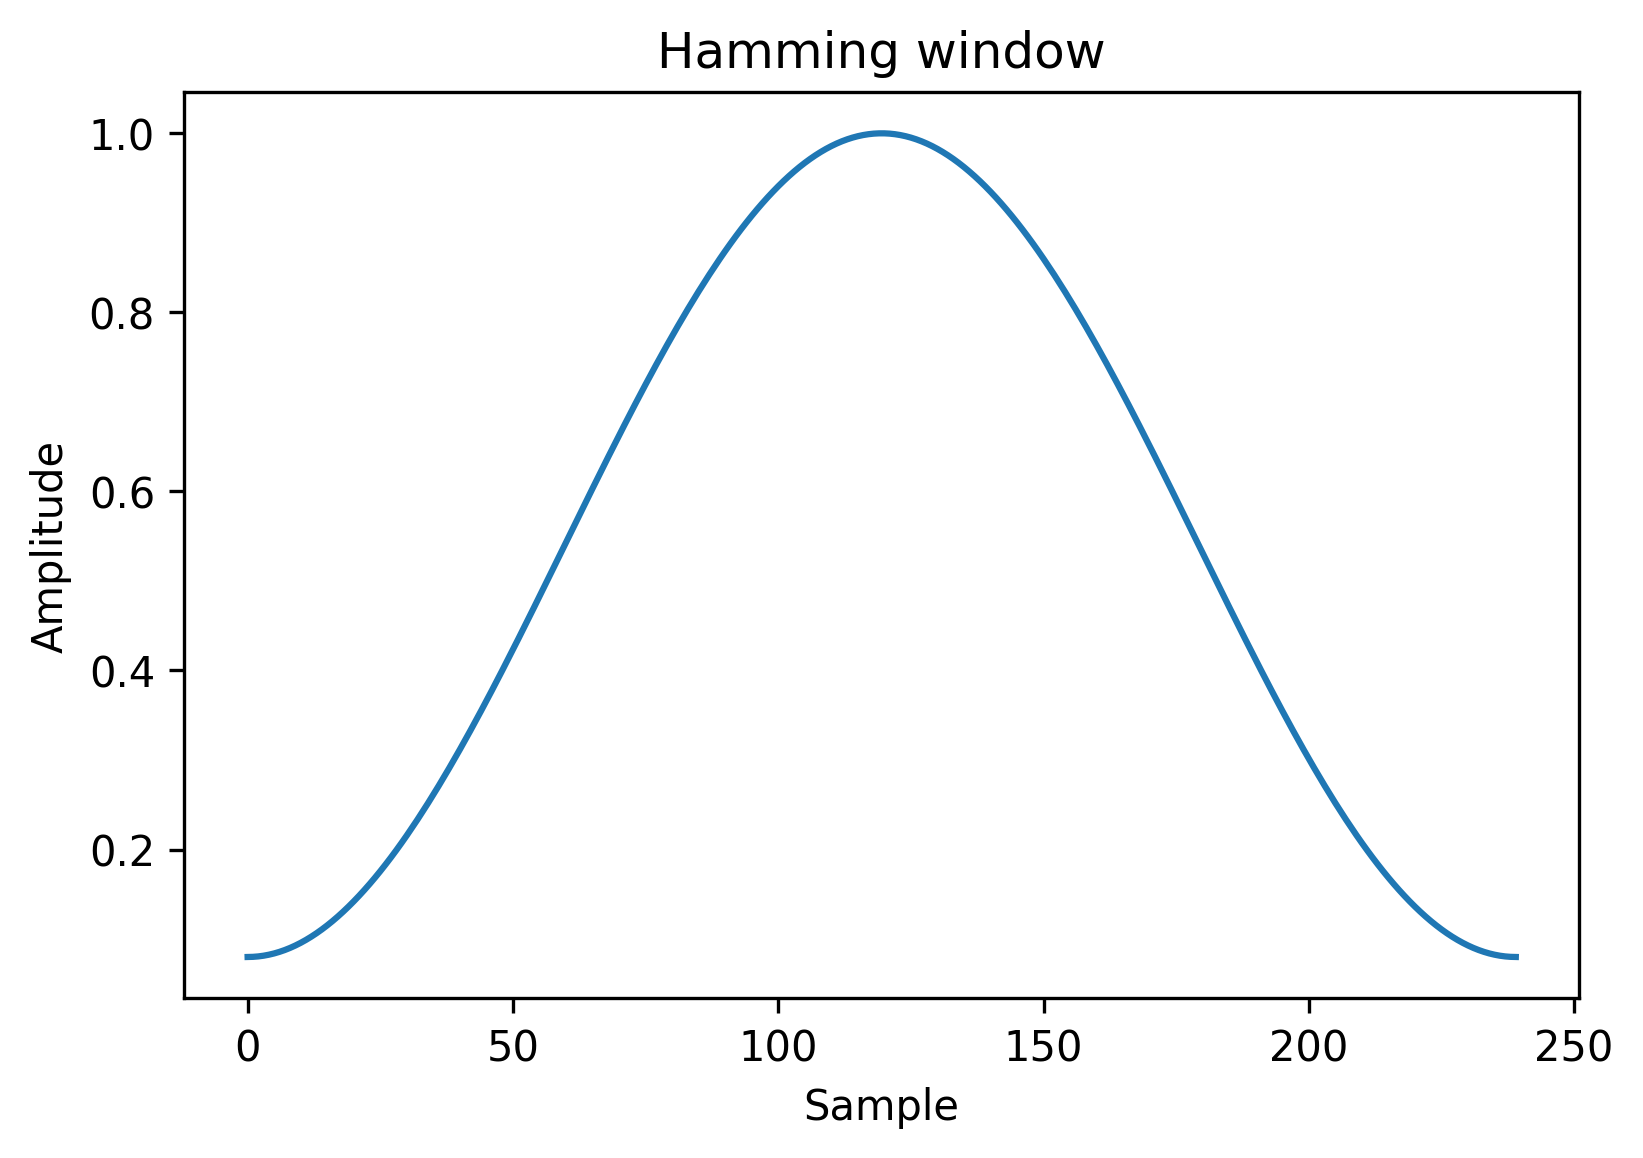

In [10]:
window = np.hamming(windowLength)
plt.gcf().set_dpi(300)
plt.plot(window) 
plt.title("Hamming window")
plt.ylabel("Amplitude") 
plt.xlabel("Sample") 
plt.show() 

## Generating the narrawband magnitude spectra
Here we multply the hamming window of appropriate length with our signal sample and take its dft. Thus, we can  generate the required magnitude plot

In [11]:
dftSize = 10000 #setting the dft size
signalAfterHamming = signalToAnalyse*np.hamming(windowLength) #choosing the hamming window
signalHammingDFT = 20*np.log10(np.abs(np.fft.fft(signalAfterHamming, dftSize))[:dftSize//2]) #computing the magnitudes of the signal afterwindowing and hamming

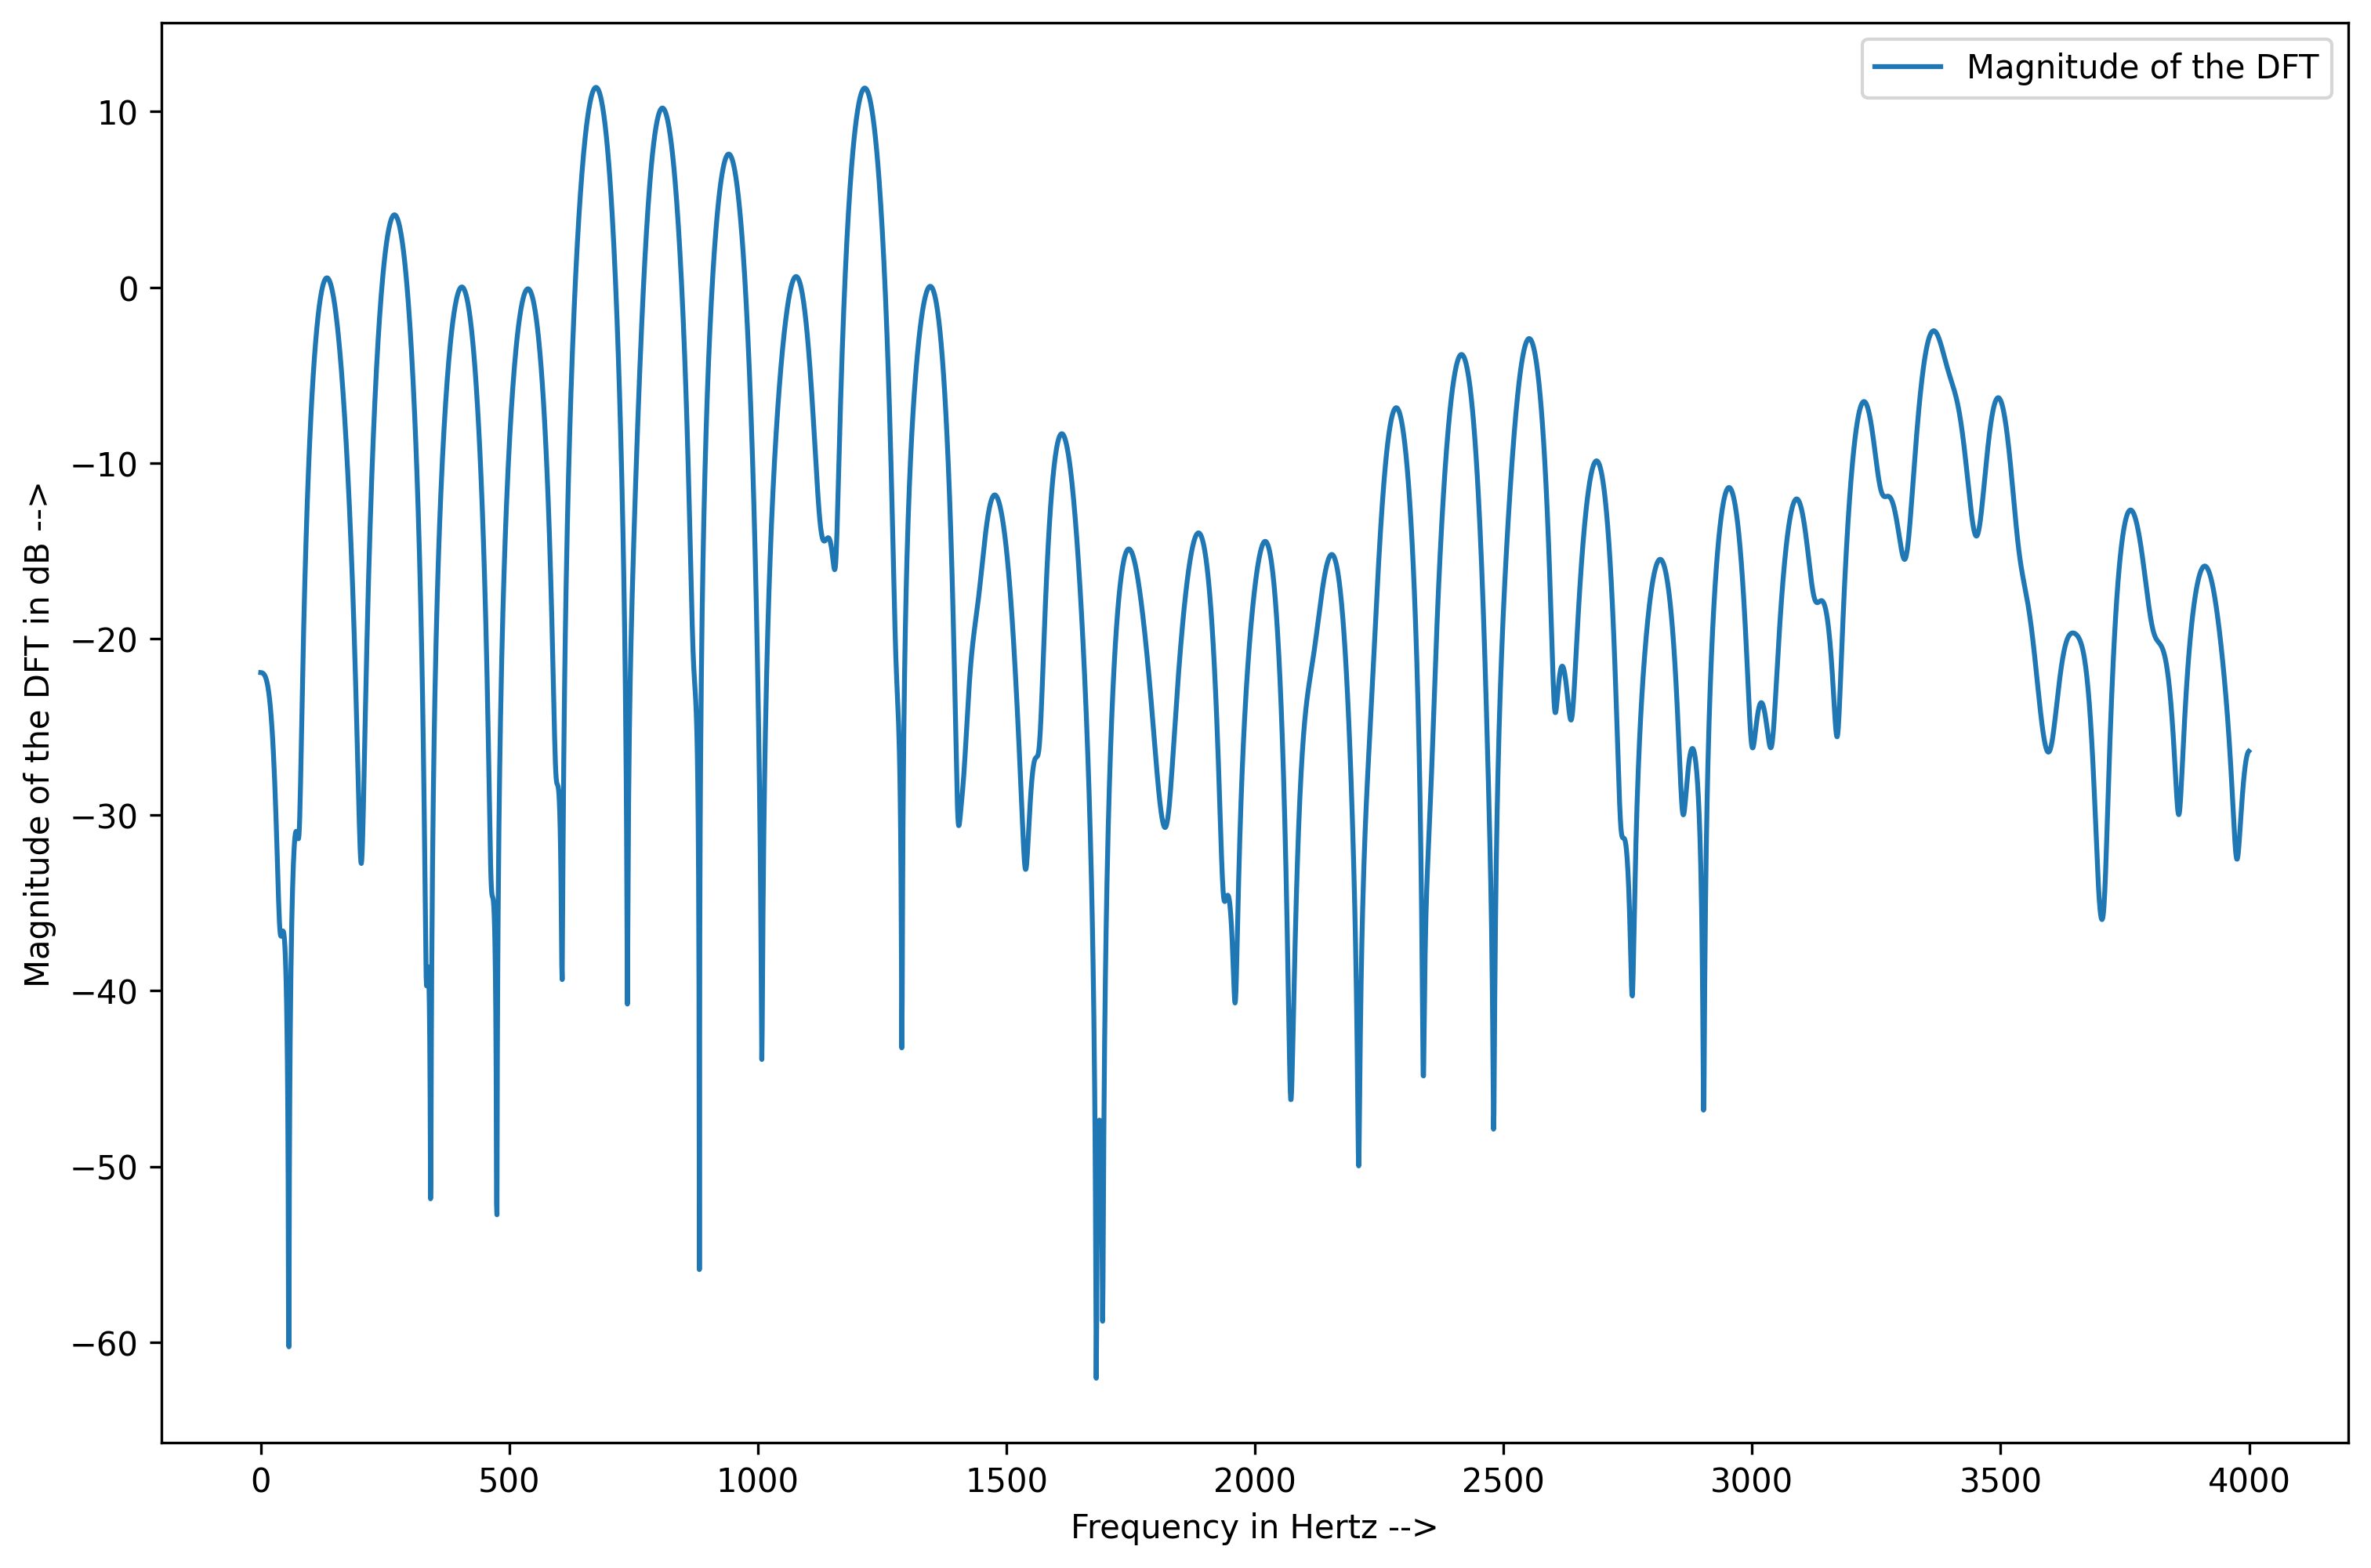

In [12]:
plt.figure(figsize=(12, 8)) #plotting the magnitude spectra for the windowed signal
plt.gcf().set_dpi(300)
plt.plot(np.arange(0, 4000, 8000/dftSize)[0:] , signalHammingDFT)
plt.xlabel("Frequency in Hertz -->")
plt.ylabel("Magnitude of the DFT in dB -->")
plt.legend(["Magnitude of the DFT"])

# Question 3
With the same 30 ms segment of part 2, compute the autocorrelation coefficients
required for LPC calculation at various p = 2,4,6,8,10. Use the Levinson-Durbin
recursion to compute the LP coefficients from the autocorrelation coefficients. Plot error
signal energy (i.e. square of gain) vs p. 

For a particular p, we only need to compute the autocorrelation functions from 0 to p-1, since only these coefficients show up in our equations.

To compute the ACF : 

$$ r(k) = \sum_{m = -M}^{M} x[m] \times x[m+k]$$

$$ \implies r(k) = \sum_{m = 0}^{2M+1} x[m] \times x[m+k] \text{(when signal is indexed from 0)} $$

Further, since our signal is windowed i.e finite length the autocorrelation is always 0 for all $ k \geq N \text{(the window length)}$

In [13]:
def computeACF(signal, lag):
    #we assume that the signal is windowed
    #padding the signal till twice the length since the signal is finite
    signal = np.array(signal, dtype = float)
    return (np.sum(np.pad(signal, (0, 3*len(signal)), 'constant')*np.pad(signal, (lag, 3*len(signal)-lag), 'constant')))

Text(0, 0.5, 'ACF Value')

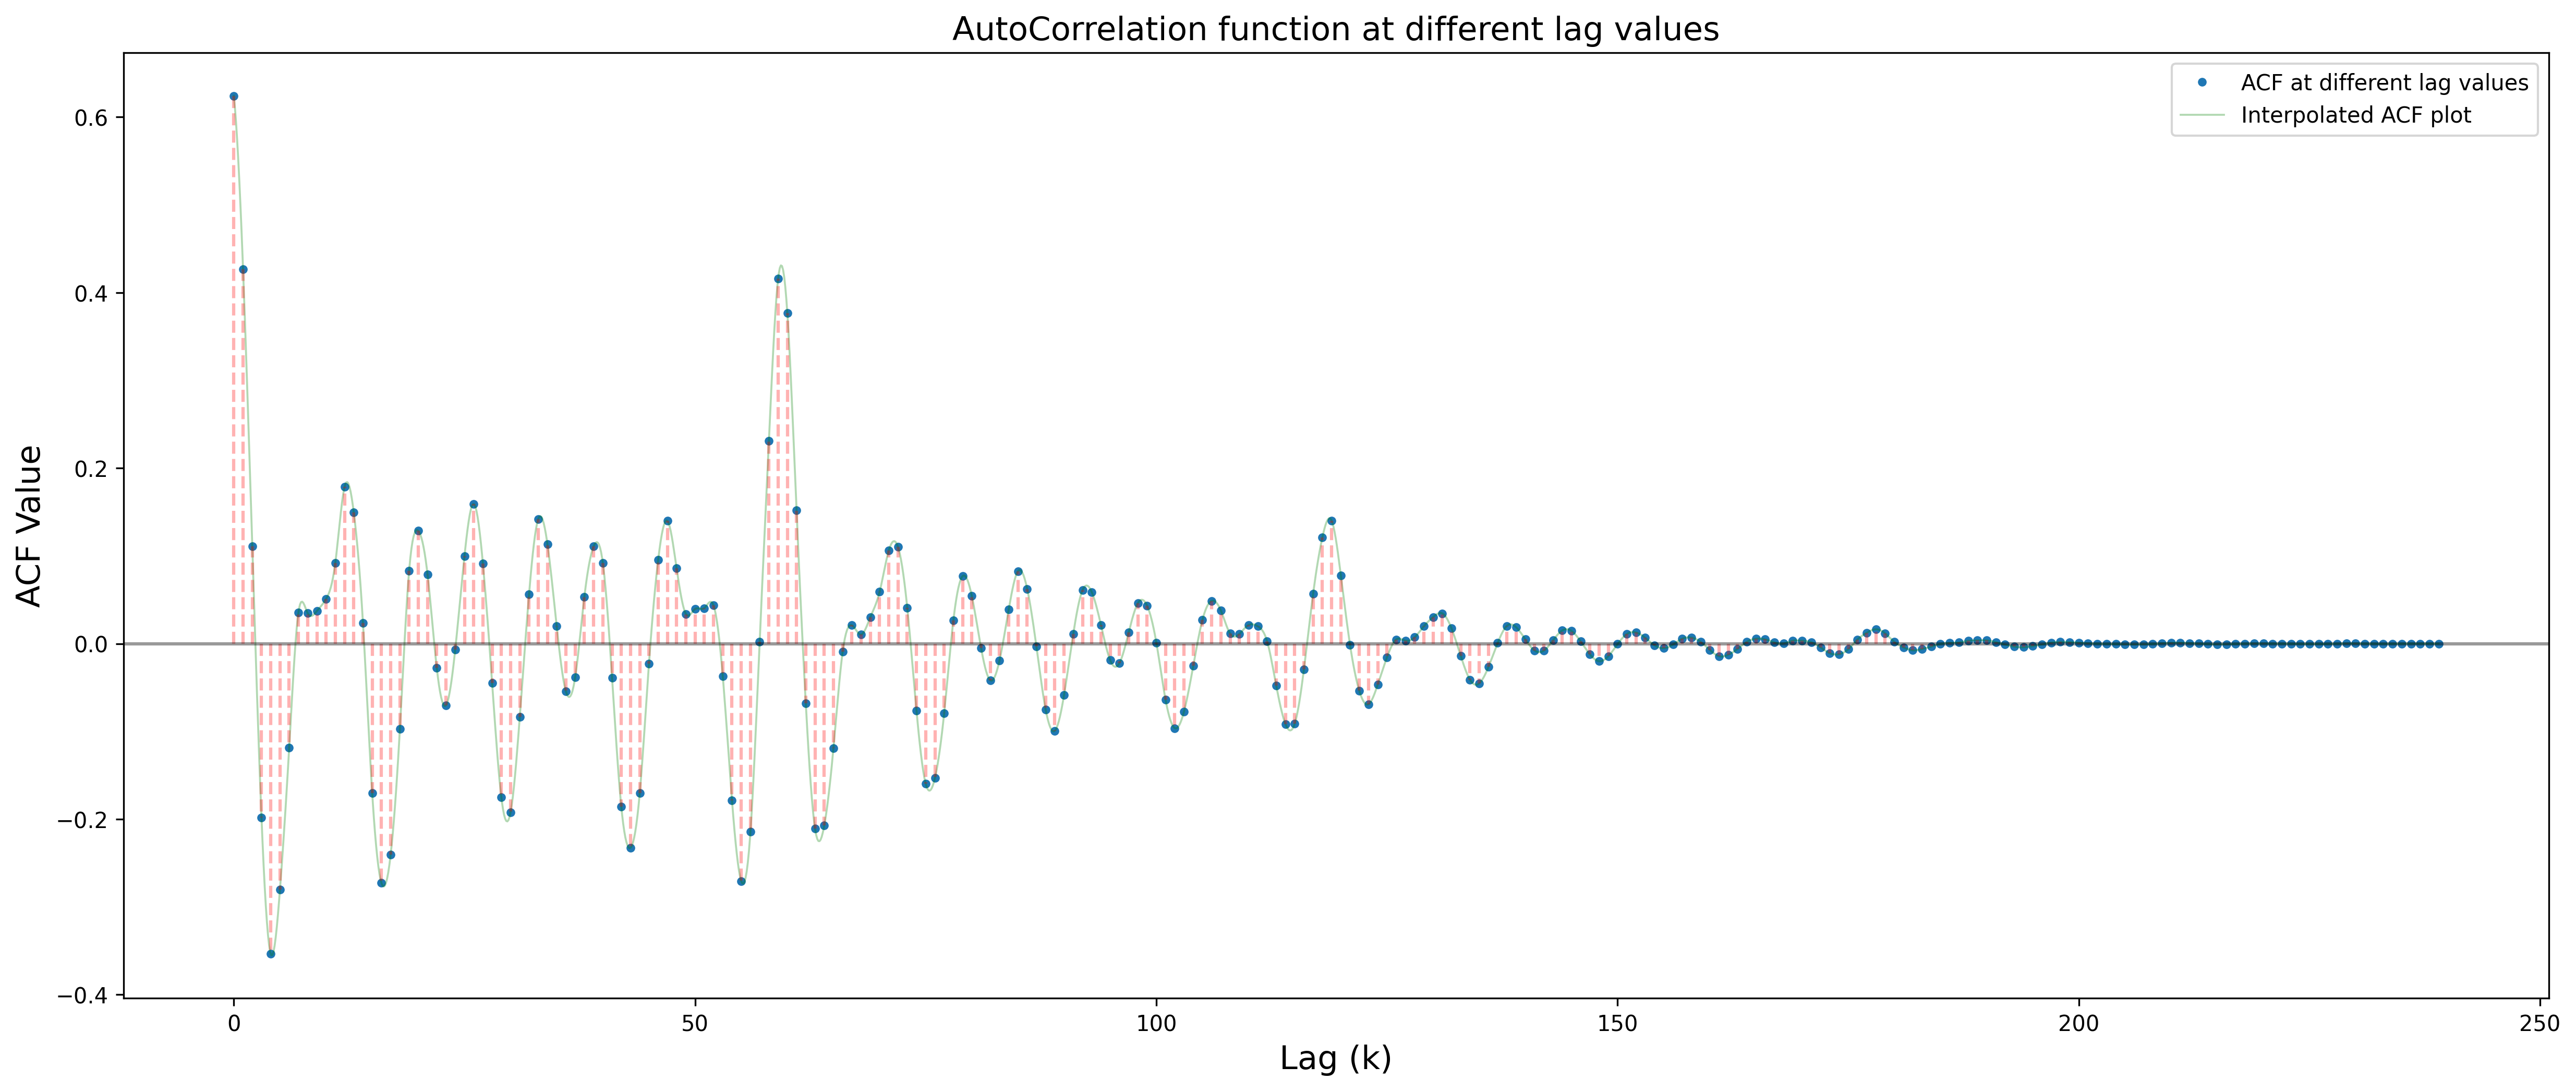

In [14]:
k = [i for i in range(0, 240)]
x = np.linspace(0, 239, 2000)
acf = [computeACF(signalAfterHamming, i) for i in range(0, 240)]
plt.figure(figsize = (20, 8))
plt.gcf().set_dpi(300)
plt.plot(k, acf,'.')
f = interp1d(k, acf, kind='cubic')
plt.plot(x, f(x), alpha = 0.3, linewidth = 0.9, color = 'g')
plt.vlines(k, 0, acf, color='r', linestyles='--', alpha = 0.3)
plt.axhline(0, color = 'k', alpha = 0.4)
plt.legend(["ACF at different lag values", "Interpolated ACF plot"])
plt.title("AutoCorrelation function at different lag values", fontsize= 15)
plt.xlabel("Lag (k)", fontsize= 15)
plt.ylabel("ACF Value", fontsize= 15)

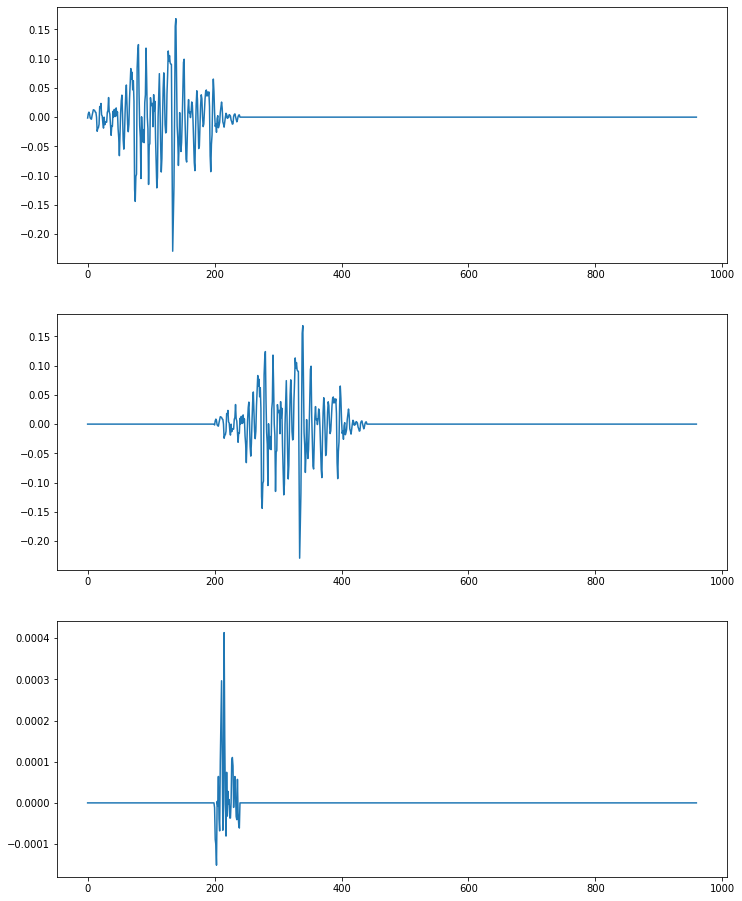

In [15]:
plt.figure(figsize=(12, 16))
plt.subplot(311)
lag = 0
plt.plot(np.pad(signalAfterHamming,(lag, 3*len(signalAfterHamming)-lag), 'constant'))
plt.subplot(312)
lag = 200
plt.plot(np.pad(signalAfterHamming,(lag, 3*len(signalAfterHamming)-lag), 'constant'))
plt.subplot(313)
lag = 200
plt.plot(np.pad(signalAfterHamming,(0, 3*len(signalAfterHamming)), 'constant')*np.pad(signalAfterHamming,(lag, 3*len(signalAfterHamming)-lag), 'constant'))

## The Levinson Durban Recursion

In [93]:
rp = np.array([computeACF(signalAfterHamming, lag = 1)])
pp = np.array([computeACF(signalAfterHamming, lag = 1)])
alpha = np.array([rp[0]/computeACF(signalAfterHamming, 0)])
beta = np.array([rp[0]/computeACF(signalAfterHamming, 0)])
coef = [alpha]

order = 40
for p in range(1, order):
    k = (computeACF(signalAfterHamming, p+1) - np.sum(pp*alpha))/(computeACF(signalAfterHamming, 0) - np.sum(rp*alpha))
    alpha = np.append(alpha, 0) - (k*np.append(beta, -1))
    beta = alpha[::-1]
    rp = np.append(rp, computeACF(signalAfterHamming, lag = p+1))
    pp = rp[::-1]
    coef.append(alpha)

In [94]:
coef

[array([0.68324235]),
 array([ 1.05373975, -0.54226353]),
 array([ 0.859931  , -0.16564962, -0.35740695]),
 array([ 0.83876511, -0.1754595 , -0.30648125, -0.05922068]),
 array([ 0.8505908 , -0.11425875, -0.27144402, -0.22671236,  0.19968842]),
 array([ 0.88591866, -0.15436754, -0.31946652, -0.24692644,  0.35017062,
        -0.17691492]),
 array([ 0.85987103, -0.10281104, -0.35582212, -0.2939623 ,  0.3274427 ,
        -0.04647888, -0.14723252]),
 array([ 0.7976631 , -0.12244906, -0.21747271, -0.41816574,  0.17710256,
        -0.08991808,  0.21607578, -0.42251487]),
 array([ 0.9961543 , -0.22395825, -0.17523053, -0.50136589,  0.3735506 ,
         0.01224737,  0.27360053, -0.79724513,  0.46978513]),
 array([ 0.91823425, -0.09172465, -0.22061078, -0.50339728,  0.31159232,
         0.0954055 ,  0.30266482, -0.76009871,  0.30455982,  0.16586317]),
 array([ 0.93315811, -0.0643213 , -0.28900211, -0.47616443,  0.32017661,
         0.12344161,  0.25737069, -0.77994858,  0.29630672,  0.24848305,


In [95]:
#checking whether the coefficient are correct
#should preserve the acf!
for p in range(1, len(coef)+1):
    computeACF(signalAfterHamming, 1) == coef[0][0]*computeACF(signalAfterHamming, 0)
    Rind = np.array([[ np.abs(i-k) for k in range(1, p+1)] for i in range(1, p+1)])
    R = np.array([[computeACF(signalAfterHamming, np.abs(i-k)) for k in range(1, p+1)] for i in range(1, p+1)])
    acfArr = np.array([computeACF(signalAfterHamming, i) for i in range(1, p+1)])
    coefArr = coef[p-1]
    if np.sum((np.round(np.matmul(R, coefArr) - acfArr, 7))**2)==0:
        print(f"Order {p} coefficients verified and correct...proceed")
    else:
        print("Error <Coefficients don't match>")
        break

Order 1 coefficients verified and correct...proceed
Order 2 coefficients verified and correct...proceed
Order 3 coefficients verified and correct...proceed
Order 4 coefficients verified and correct...proceed
Order 5 coefficients verified and correct...proceed
Order 6 coefficients verified and correct...proceed
Order 7 coefficients verified and correct...proceed
Order 8 coefficients verified and correct...proceed
Order 9 coefficients verified and correct...proceed
Order 10 coefficients verified and correct...proceed
Order 11 coefficients verified and correct...proceed
Order 12 coefficients verified and correct...proceed
Order 13 coefficients verified and correct...proceed
Order 14 coefficients verified and correct...proceed
Order 15 coefficients verified and correct...proceed
Order 16 coefficients verified and correct...proceed
Order 17 coefficients verified and correct...proceed
Order 18 coefficients verified and correct...proceed
Order 19 coefficients verified and correct...proceed
Or

In [96]:
#computing the minima energy directly from formula
Emin = []
for p in range(1,len(coef)+1):
    acfArr = np.array([computeACF(signalAfterHamming, i) for i in range(1, p+1)])
    E = computeACF(signalAfterHamming, 0) - np.sum(acfArr*coef[p-1])
    Emin.append(E)

In [97]:
error = []
for p in range(1, len(coef)+1):
    signalToEstimate = np.pad(np.array(signalToAnalyse, dtype = float),(p, 3*len(signalToAnalyse)-p), 'constant')
    signalEstimate = np.zeros_like(signalToEstimate)
    for i in range(0, len(signalToAnalyse) + p-1):
        signalEstimate[i] = np.sum(signalToEstimate[i:(i+p)]*coef[p-1])
    error.append(np.sum((signalToEstimate - signalEstimate)**2))

## Error plots !!!!!![CHECK this shit]

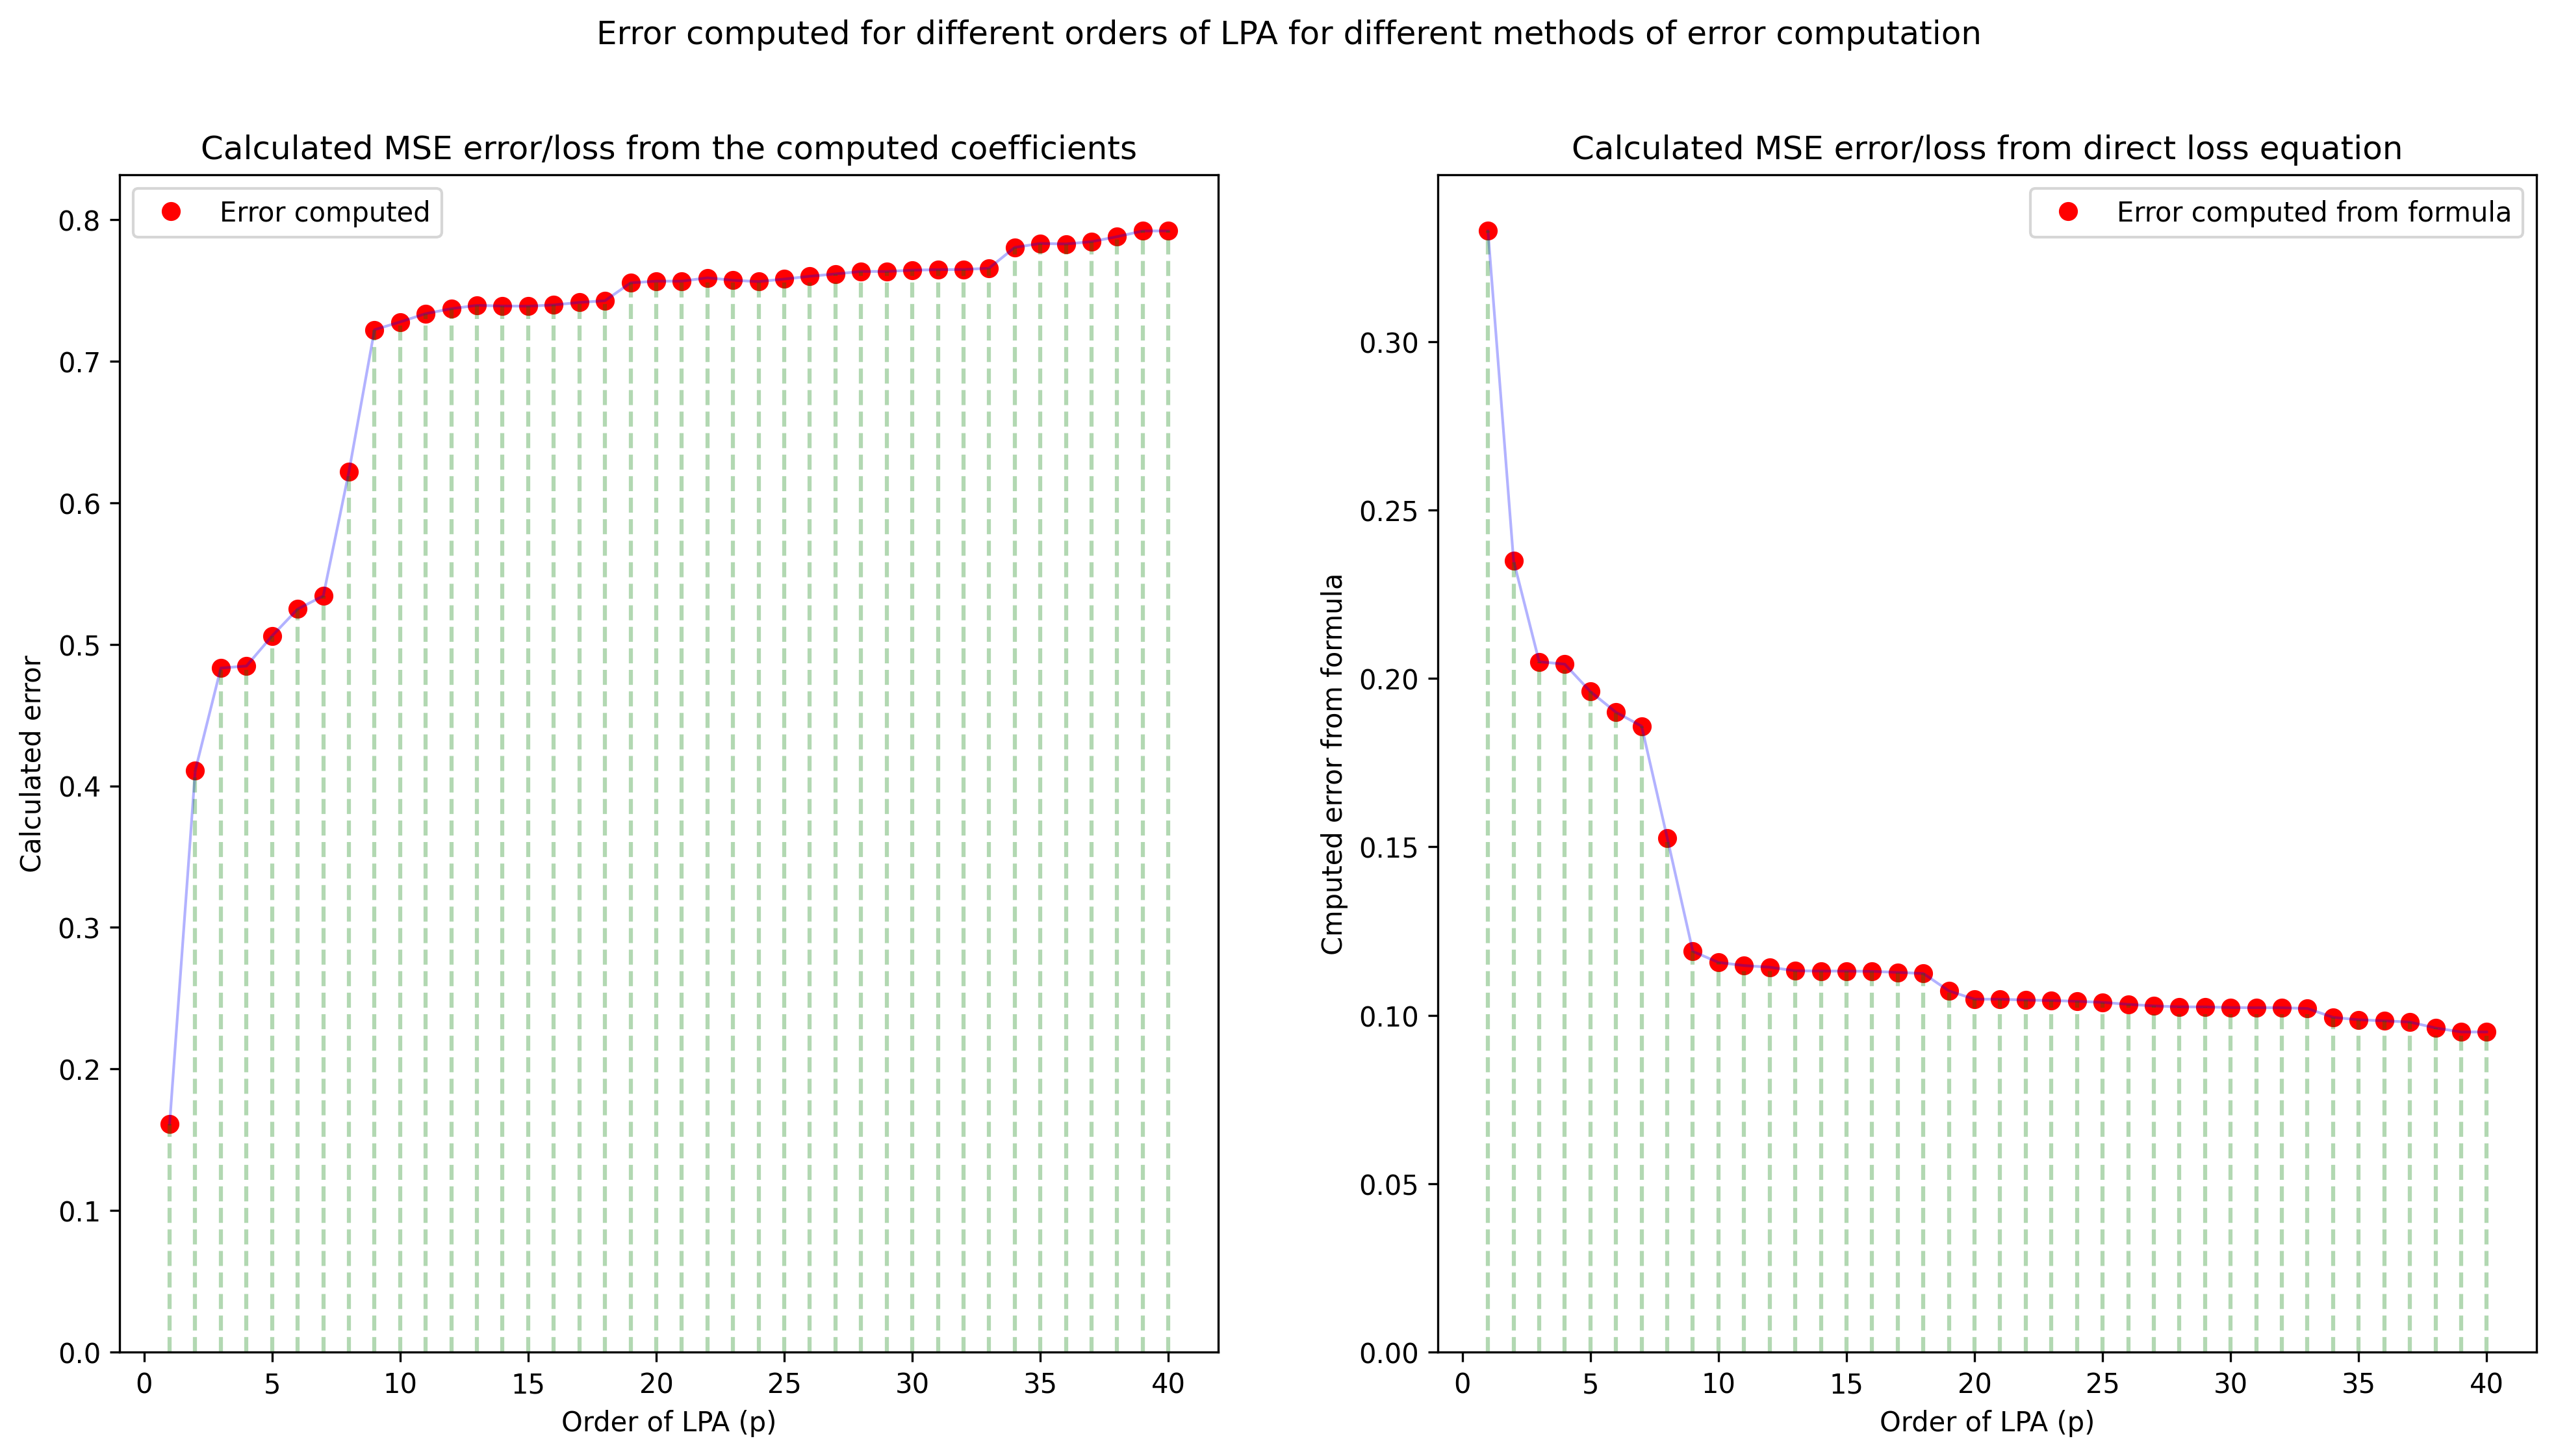

In [99]:
plt.figure(figsize=(16, 8))
plt.gcf().set_dpi(300)
plt.suptitle("Error computed for different orders of LPA for different methods of error computation")
plt.subplot(121)
plt.plot([i for i in range(1, order + 1)], error, 'ro')
plt.plot([i for i in range(1, order + 1)],  error, 'b', alpha = 0.3, linewidth = 1)
plt.vlines([i for i in range(1, order + 1)] , 0, error, color='g', linestyles='--', alpha = 0.3)
plt.ylim(bottom=0)
plt.title("Calculated MSE error/loss from the computed coefficients")
plt.xlabel("Order of LPA (p)")
plt.ylabel("Calculated error")
plt.legend(["Error computed"])
plt.subplot(122)
plt.plot([i for i in range(1, order + 1)], Emin, 'ro')
plt.plot([i for i in range(1, order + 1)], Emin, 'b', alpha = 0.3, linewidth = 1)
plt.vlines([i for i in range(1, order + 1)] , 0, Emin, color='g', linestyles='--', alpha = 0.3)
plt.ylim(bottom=0)
plt.title("Calculated MSE error/loss from direct loss equation")
plt.xlabel("Order of LPA (p)")
plt.ylabel("Cmputed error from formula")
plt.legend(["Error computed from formula"])

## Inference
1. We see that the computed loss and the calculated loss both reduce as p increases and finally settle at minima around p=40
2. This is expected since higher order lpa approximated the system better than lower order lpa


# Question 4
Show the pole-zero plots of the estimated all-pole filter for p=6,10; comment. 

## Order of lpa p=6

In [27]:
z, p, k =tf2zpk(np.sqrt(Emin[5]), [1] + coef[5])

In [28]:
#Zeros
z

array([], dtype=float64)

In [29]:
#poles
p

array([ 0.59092661+0.76729225j,  0.59092661-0.76729225j,
       -0.48790629+0.68773016j, -0.48790629-0.68773016j,
       -0.65443348+0.j        ])

(-1.1, 1.1)

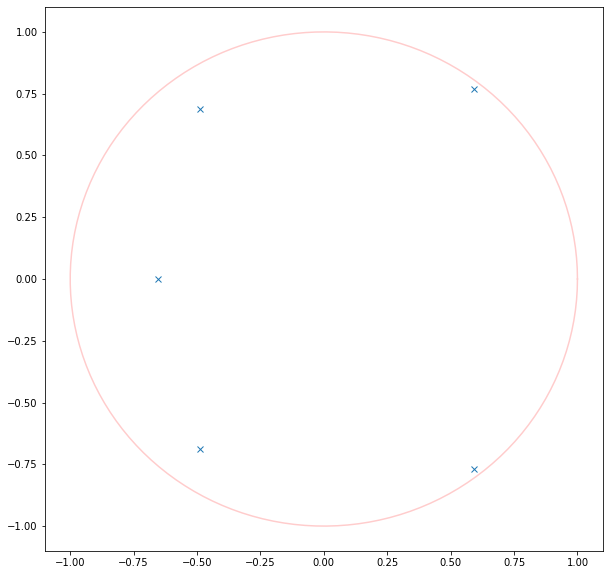

In [30]:
angle = np.linspace( 0 , 2 * np.pi , 150 ) 

radius = 1

x = radius * np.cos( angle ) 
y = radius * np.sin( angle )
plt.figure(figsize=(10,10)) 
plt.plot(x, y, 'r', alpha = 0.2)
plt.plot([i.real for i in p], [j.imag for j in p], 'x')
plt.xlim([-1.1, 1.1])
plt.ylim([-1.1, 1.1])

## Order of lpa p=10

In [33]:
z, p, k =tf2zpk(np.sqrt(Emin[9]),np.insert((-1*coef[9]),  0, 1))

In [34]:
#Zeros
z

array([], dtype=float64)

In [35]:
#poles
p

array([ 0.56151412+0.7865969j ,  0.56151412-0.7865969j ,
        0.83572563+0.j        ,  0.80338857+0.51448381j,
        0.80338857-0.51448381j, -0.33686529+0.87186621j,
       -0.33686529-0.87186621j, -0.83820828+0.44355255j,
       -0.83820828-0.44355255j, -0.29714962+0.j        ])

(-1.1, 1.1)

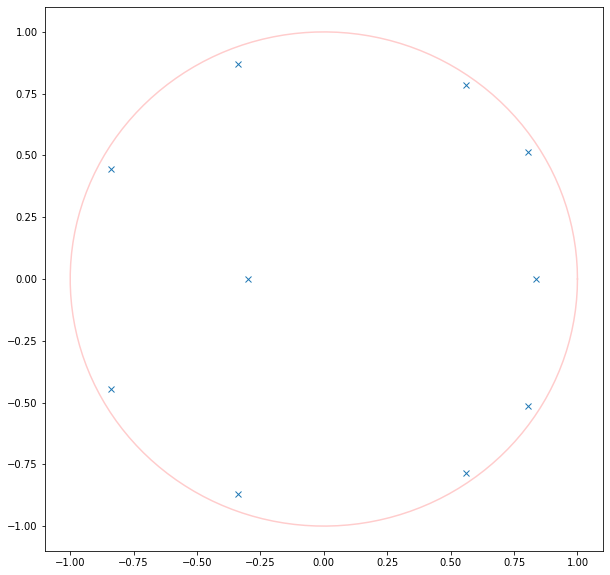

In [36]:
angle = np.linspace( 0 , 2 * np.pi , 150 ) 

radius = 1

x = radius * np.cos( angle ) 
y = radius * np.sin( angle )
plt.figure(figsize=(10,10)) 
plt.plot(x, y, 'r', alpha = 0.2)
plt.plot([i.real for i in p], [j.imag for j in p], 'x')
plt.xlim([-1.1, 1.1])
plt.ylim([-1.1, 1.1])

## Comments:
1. We see that most poles lie very close to the unit circle
2. We see a pole lying on the real axis in both cases (two poles have the same value i.e the real pole)
3. The real pole has actually 2 poles at the same place hence we see the correct number of poles in each case

# Question 5
1. Compute the gain   
 and 
2. plot the LPC spectrum magnitude (i.e. the dB magnitude
frequency response of the estimated all-pole filter) for each order "p". 
3. Comment on the characteristics of the spectral envelope estimates. 
4. Comment on their shapes with
reference to the short-time magnitude spectrum computed in part 2. 

## Gain 
Gain is obtained as follows $G = \sqrt{E_{min}}$

In [23]:
#can we obtained by sqrt(Emin)

for i in range(0, order):
    print(f"Gain for order {i+1} lpa is {np.sqrt(Emin[i])}")

Gain for order 1 lpa is 0.5769352396029351
Gain for order 2 lpa is 0.4847458717996041
Gain for order 3 lpa is 0.4527278019216045
Gain for order 4 lpa is 0.4519332262018964
Gain for order 5 lpa is 0.4428310411639762
Gain for order 6 lpa is 0.4358458902477001
Gain for order 7 lpa is 0.431096001946366
Gain for order 8 lpa is 0.39072644399883605
Gain for order 9 lpa is 0.34492580165807823
Gain for order 10 lpa is 0.3401481571957841
Gain for order 11 lpa is 0.33876846591442067
Gain for order 12 lpa is 0.3380523437850977
Gain for order 13 lpa is 0.3364705250047146
Gain for order 14 lpa is 0.3363601545681334
Gain for order 15 lpa is 0.3363382990148193
Gain for order 16 lpa is 0.336233982320882
Gain for order 17 lpa is 0.33576397014077075
Gain for order 18 lpa is 0.33529145815755196
Gain for order 19 lpa is 0.3274853835278537
Gain for order 20 lpa is 0.3236974778824035
Gain for order 21 lpa is 0.3236974488634085
Gain for order 22 lpa is 0.32330153717820254
Gain for order 23 lpa is 0.3230951417

## LPC spectra magnitude plots

### For order p = 2

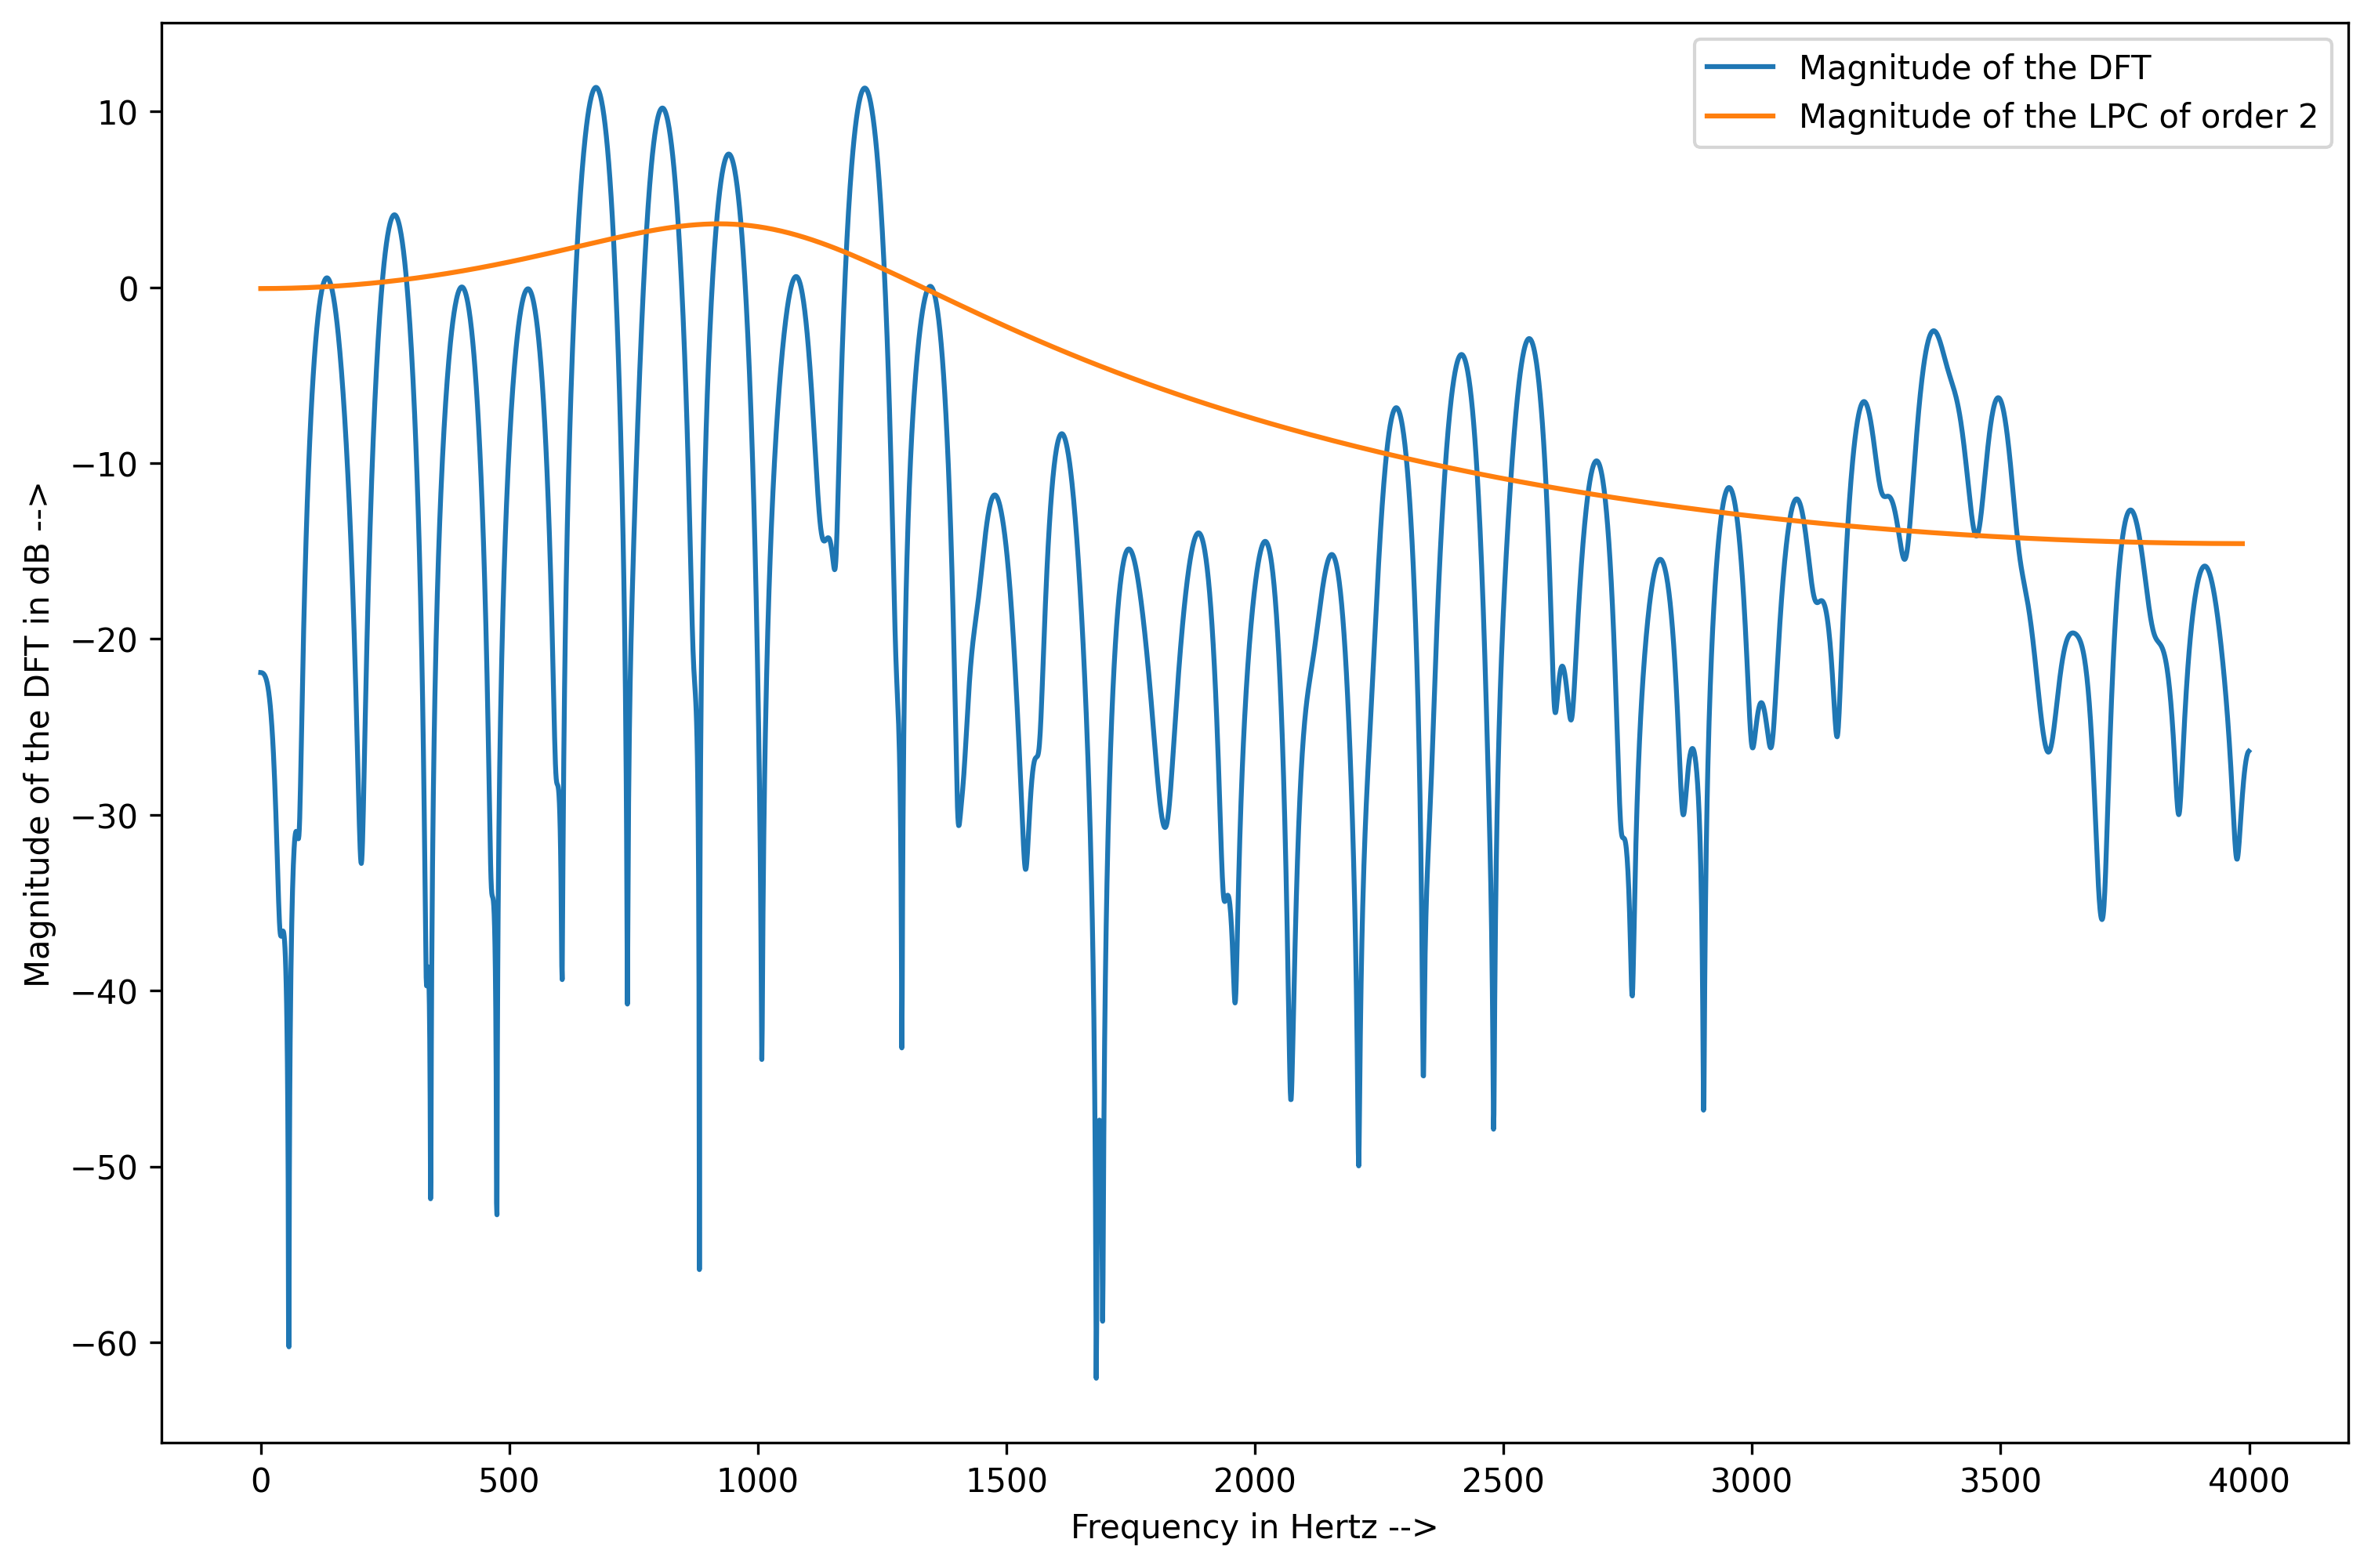

In [37]:
p = 2

signalToEstimate = np.pad(np.array(signalToAnalyse, dtype = float),(p, 3*len(signalToAnalyse)-p), 'constant')
signalEstimate = np.zeros_like(signalToEstimate)
for i in range(0, len(signalToAnalyse) + p-1):
    signalEstimate[i] = np.sum(signalToEstimate[i:(i+p)]*coef[p-1])

w, h = freqz(np.sqrt(Emin[p-1]), np.insert((-1*coef[p-1]),  0, 1), None, 1)

plt.figure(figsize=(12, 8)) #plotting the magnitude spectra for the windowed signal
plt.gcf().set_dpi(300)
#plt.subplot(121)
plt.plot(np.arange(0, 8000/2, 8000/dftSize)[0:], 20*np.log10(np.abs(np.fft.fft(signalAfterHamming, dftSize))[:dftSize//2]))
plt.plot(w[:int(len(w)/2)]*8000/(2*3.14), 20*np.log10(np.abs(h[:int(len(h)/2)])))  

plt.xlabel("Frequency in Hertz -->")
plt.ylabel("Magnitude of the DFT in dB -->")
plt.legend(["Magnitude of the DFT", f"Magnitude of the LPC of order {p}"])
# plt.subplot(122)
# f = interp1d(find_peaks(20*np.log(np.abs(np.fft.fft(signalToEstimate, dftSize))[:dftSize//2]))[0], 20*np.log(np.abs(np.fft.fft(signalToEstimate, dftSize))[:dftSize//2])[find_peaks(20*np.log(np.abs(np.fft.fft(signalToEstimate, dftSize))[:dftSize//2]))[0]], kind='cubic')
# xNew = np.array([i for i in range(21, 4000)])
# plt.plot(xNew, f(xNew), alpha = 0.3, linewidth = 0.9, color = 'g')
# plt.xlabel("Frequency in Hertz -->")
# plt.ylabel("Magnitude of the DFT in dB -->")
# plt.legend(["Interpolated Magnitude of the DFT"])

### For order p = 4

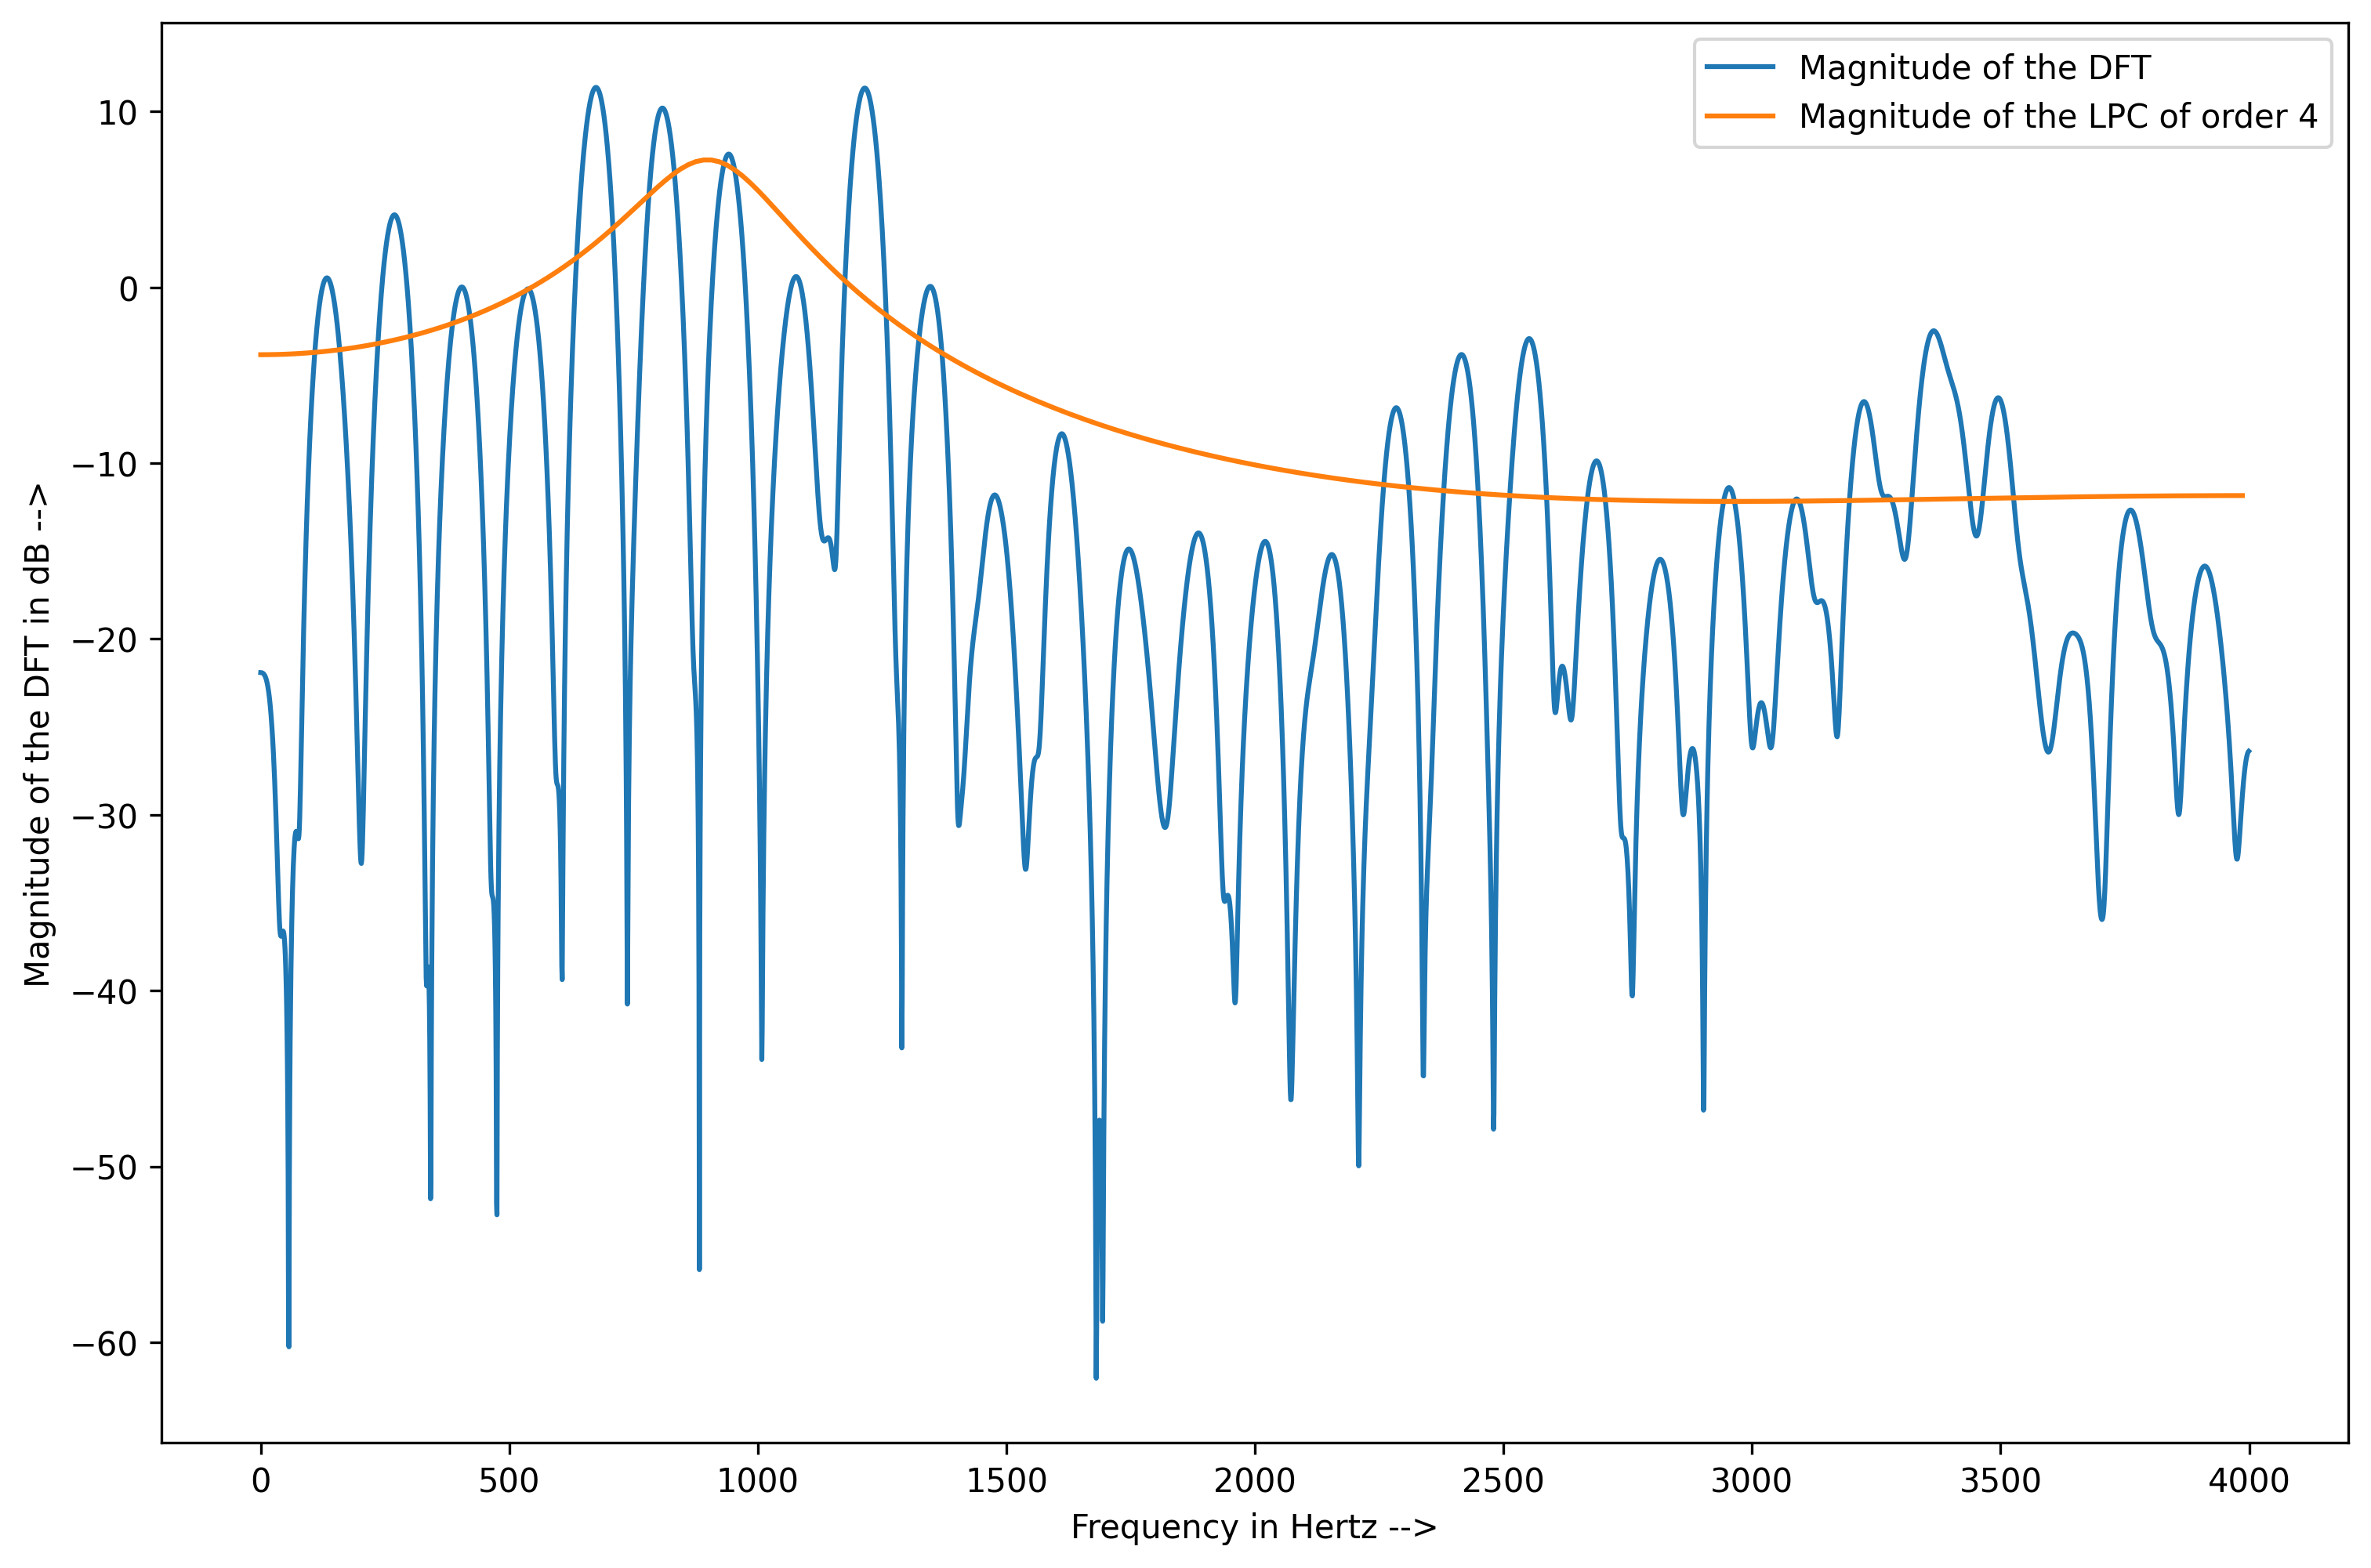

In [38]:
p = 4

signalToEstimate = np.pad(np.array(signalToAnalyse, dtype = float),(p, 3*len(signalToAnalyse)-p), 'constant')
signalEstimate = np.zeros_like(signalToEstimate)
for i in range(0, len(signalToAnalyse) + p-1):
    signalEstimate[i] = np.sum(signalToEstimate[i:(i+p)]*coef[p-1])

w, h = freqz(np.sqrt(Emin[p-1]), np.insert((-1*coef[p-1]),  0, 1), None, 1)

plt.figure(figsize=(12, 8)) #plotting the magnitude spectra for the windowed signal
plt.gcf().set_dpi(300)
#plt.subplot(121)
plt.plot(np.arange(0, 8000/2, 8000/dftSize)[0:], 20*np.log10(np.abs(np.fft.fft(signalAfterHamming, dftSize))[:dftSize//2]))
plt.plot(w[:int(len(w)/2)]*8000/(2*3.14), 20*np.log10(np.abs(h[:int(len(h)/2)])))  

plt.xlabel("Frequency in Hertz -->")
plt.ylabel("Magnitude of the DFT in dB -->")
plt.legend(["Magnitude of the DFT", f"Magnitude of the LPC of order {p}"])
# plt.subplot(122)
# f = interp1d(find_peaks(20*np.log(np.abs(np.fft.fft(signalToEstimate, dftSize))[:dftSize//2]))[0], 20*np.log(np.abs(np.fft.fft(signalToEstimate, dftSize))[:dftSize//2])[find_peaks(20*np.log(np.abs(np.fft.fft(signalToEstimate, dftSize))[:dftSize//2]))[0]], kind='cubic')
# xNew = np.array([i for i in range(21, 4000)])
# plt.plot(xNew, f(xNew), alpha = 0.3, linewidth = 0.9, color = 'g')
# plt.xlabel("Frequency in Hertz -->")
# plt.ylabel("Magnitude of the DFT in dB -->")
# plt.legend(["Interpolated Magnitude of the DFT"])

### For order p = 6

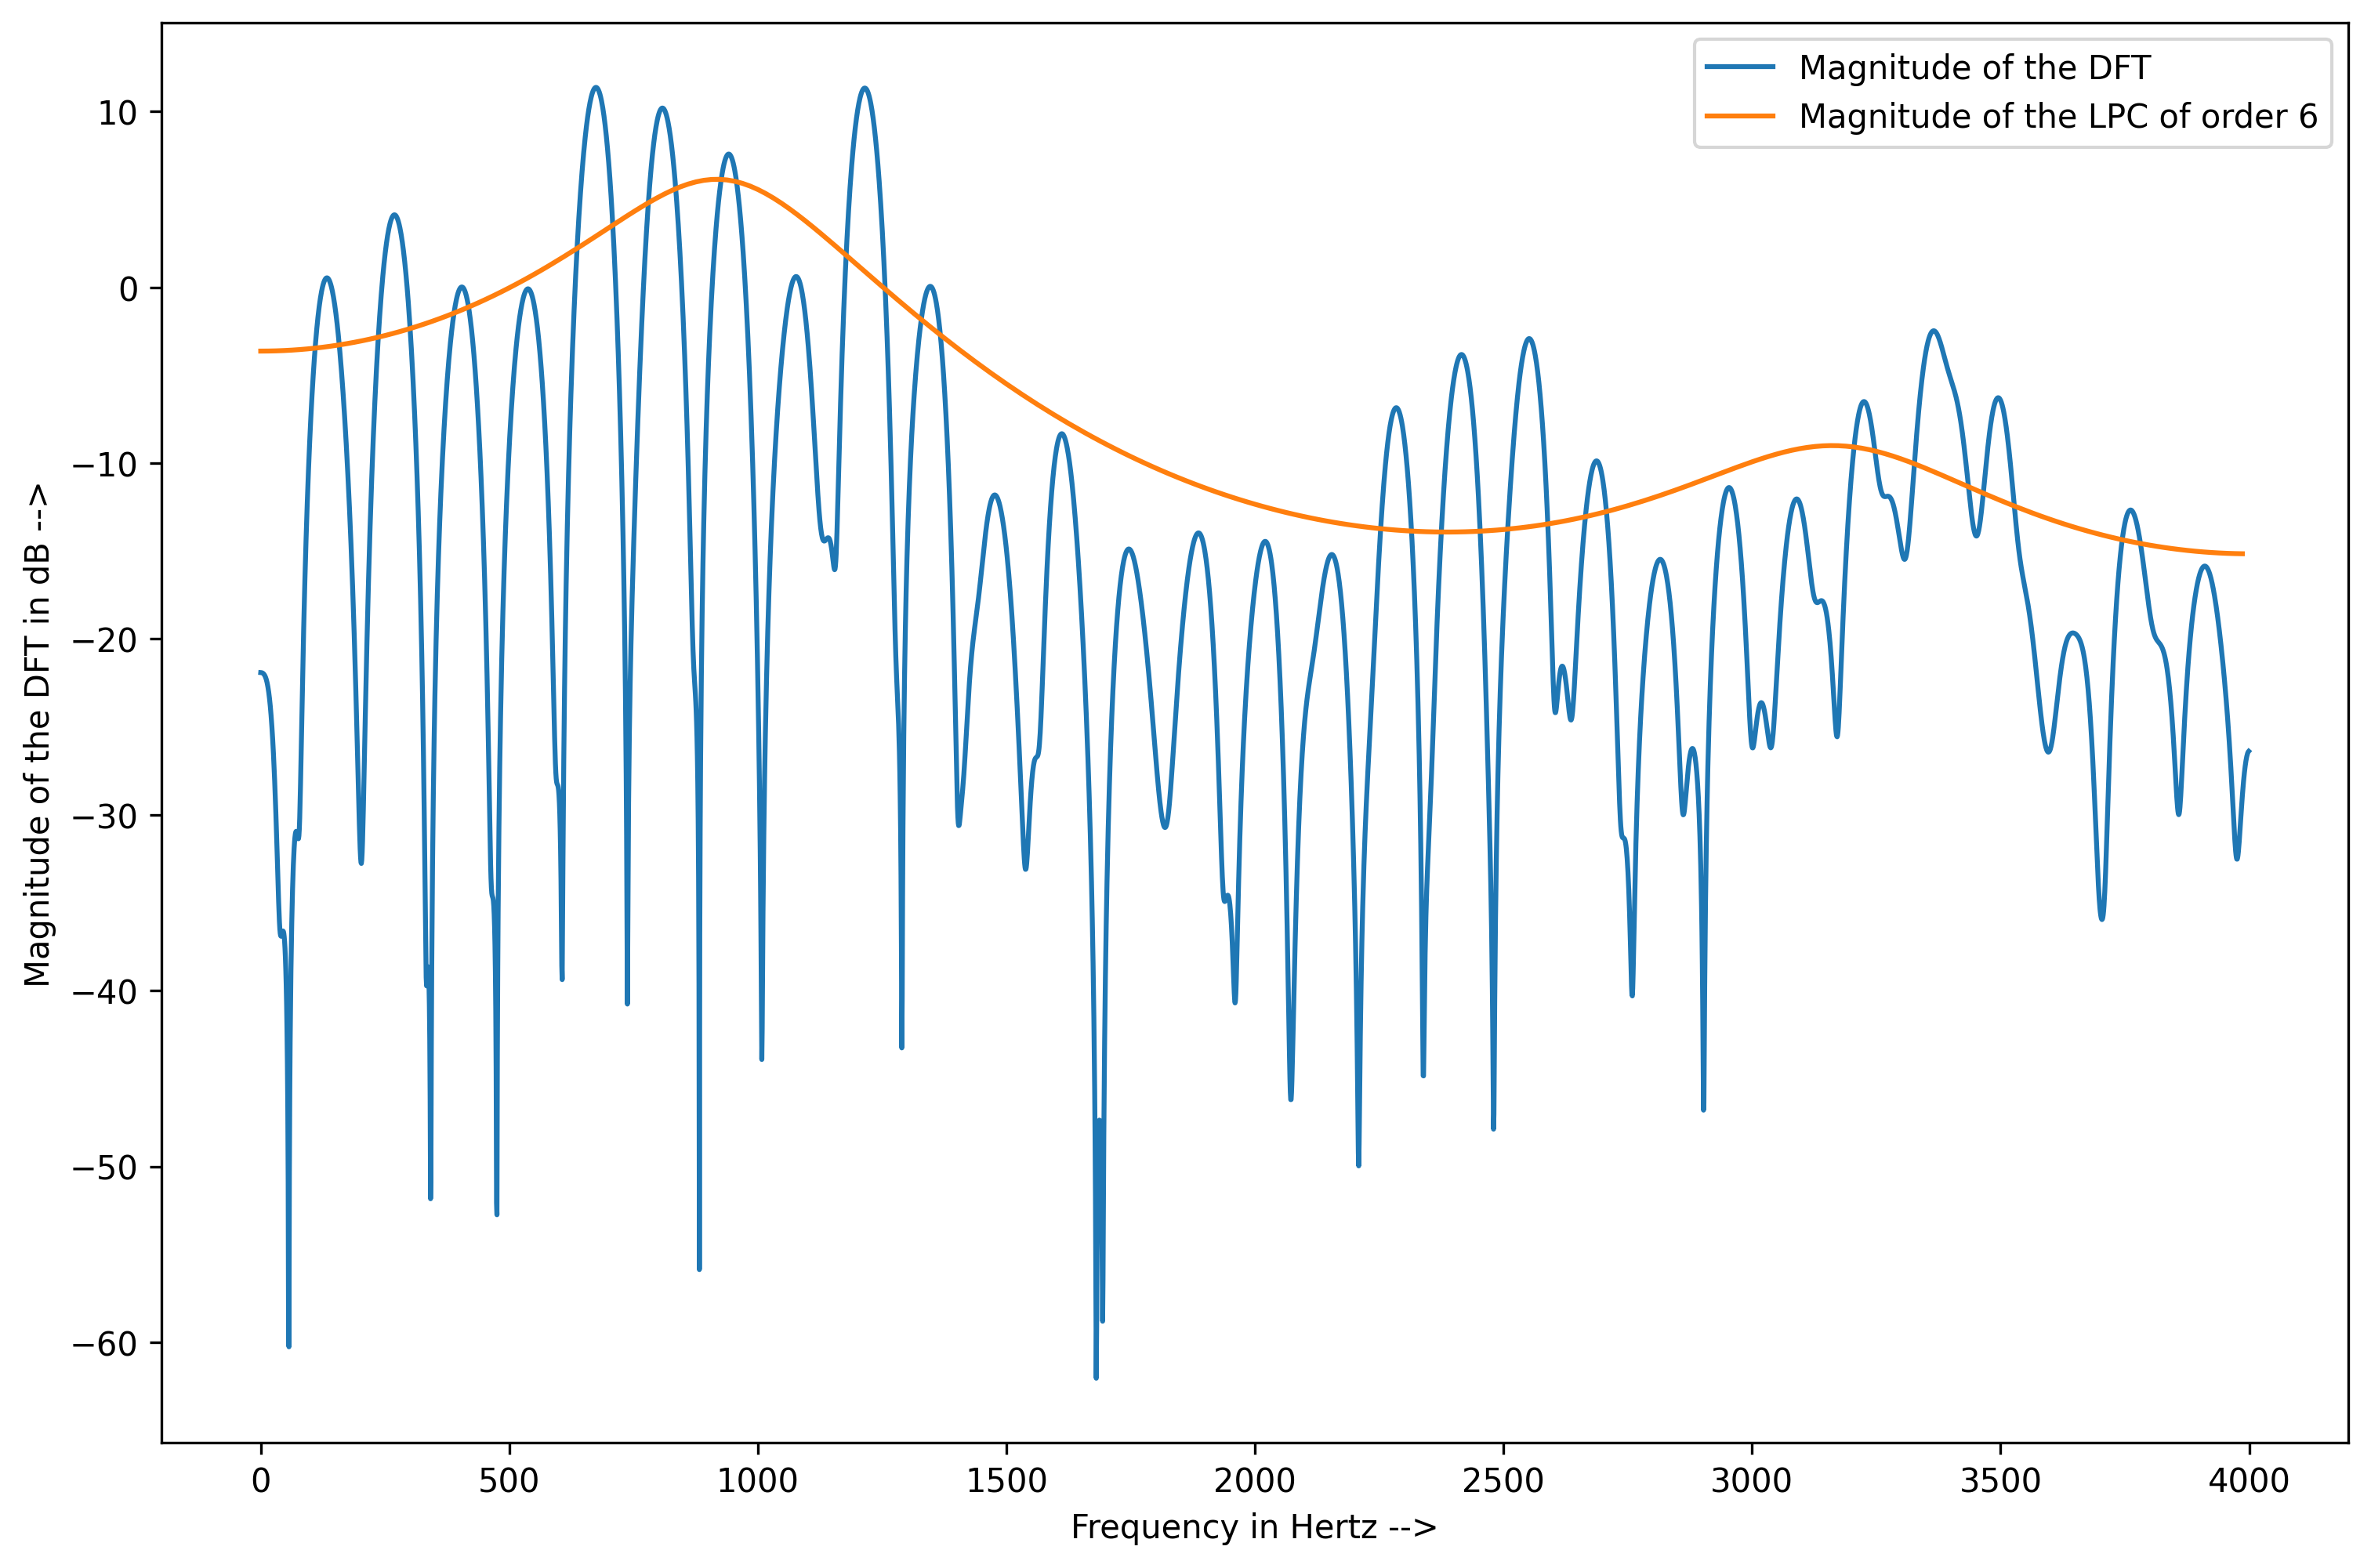

In [39]:
p = 6

signalToEstimate = np.pad(np.array(signalToAnalyse, dtype = float),(p, 3*len(signalToAnalyse)-p), 'constant')
signalEstimate = np.zeros_like(signalToEstimate)
for i in range(0, len(signalToAnalyse) + p-1):
    signalEstimate[i] = np.sum(signalToEstimate[i:(i+p)]*coef[p-1])

w, h = freqz(np.sqrt(Emin[p-1]), np.insert((-1*coef[p-1]),  0, 1), None, 1)

plt.figure(figsize=(12, 8)) #plotting the magnitude spectra for the windowed signal
plt.gcf().set_dpi(300)
#plt.subplot(121)
plt.plot(np.arange(0, 8000/2, 8000/dftSize)[0:], 20*np.log10(np.abs(np.fft.fft(signalAfterHamming, dftSize))[:dftSize//2]))
plt.plot(w[:int(len(w)/2)]*8000/(2*3.14), 20*np.log10(np.abs(h[:int(len(h)/2)])))  

plt.xlabel("Frequency in Hertz -->")
plt.ylabel("Magnitude of the DFT in dB -->")
plt.legend(["Magnitude of the DFT", f"Magnitude of the LPC of order {p}"])
# plt.subplot(122)
# f = interp1d(find_peaks(20*np.log(np.abs(np.fft.fft(signalToEstimate, dftSize))[:dftSize//2]))[0], 20*np.log(np.abs(np.fft.fft(signalToEstimate, dftSize))[:dftSize//2])[find_peaks(20*np.log(np.abs(np.fft.fft(signalToEstimate, dftSize))[:dftSize//2]))[0]], kind='cubic')
# xNew = np.array([i for i in range(21, 4000)])
# plt.plot(xNew, f(xNew), alpha = 0.3, linewidth = 0.9, color = 'g')
# plt.xlabel("Frequency in Hertz -->")
# plt.ylabel("Magnitude of the DFT in dB -->")
# plt.legend(["Interpolated Magnitude of the DFT"])

### For order p = 8

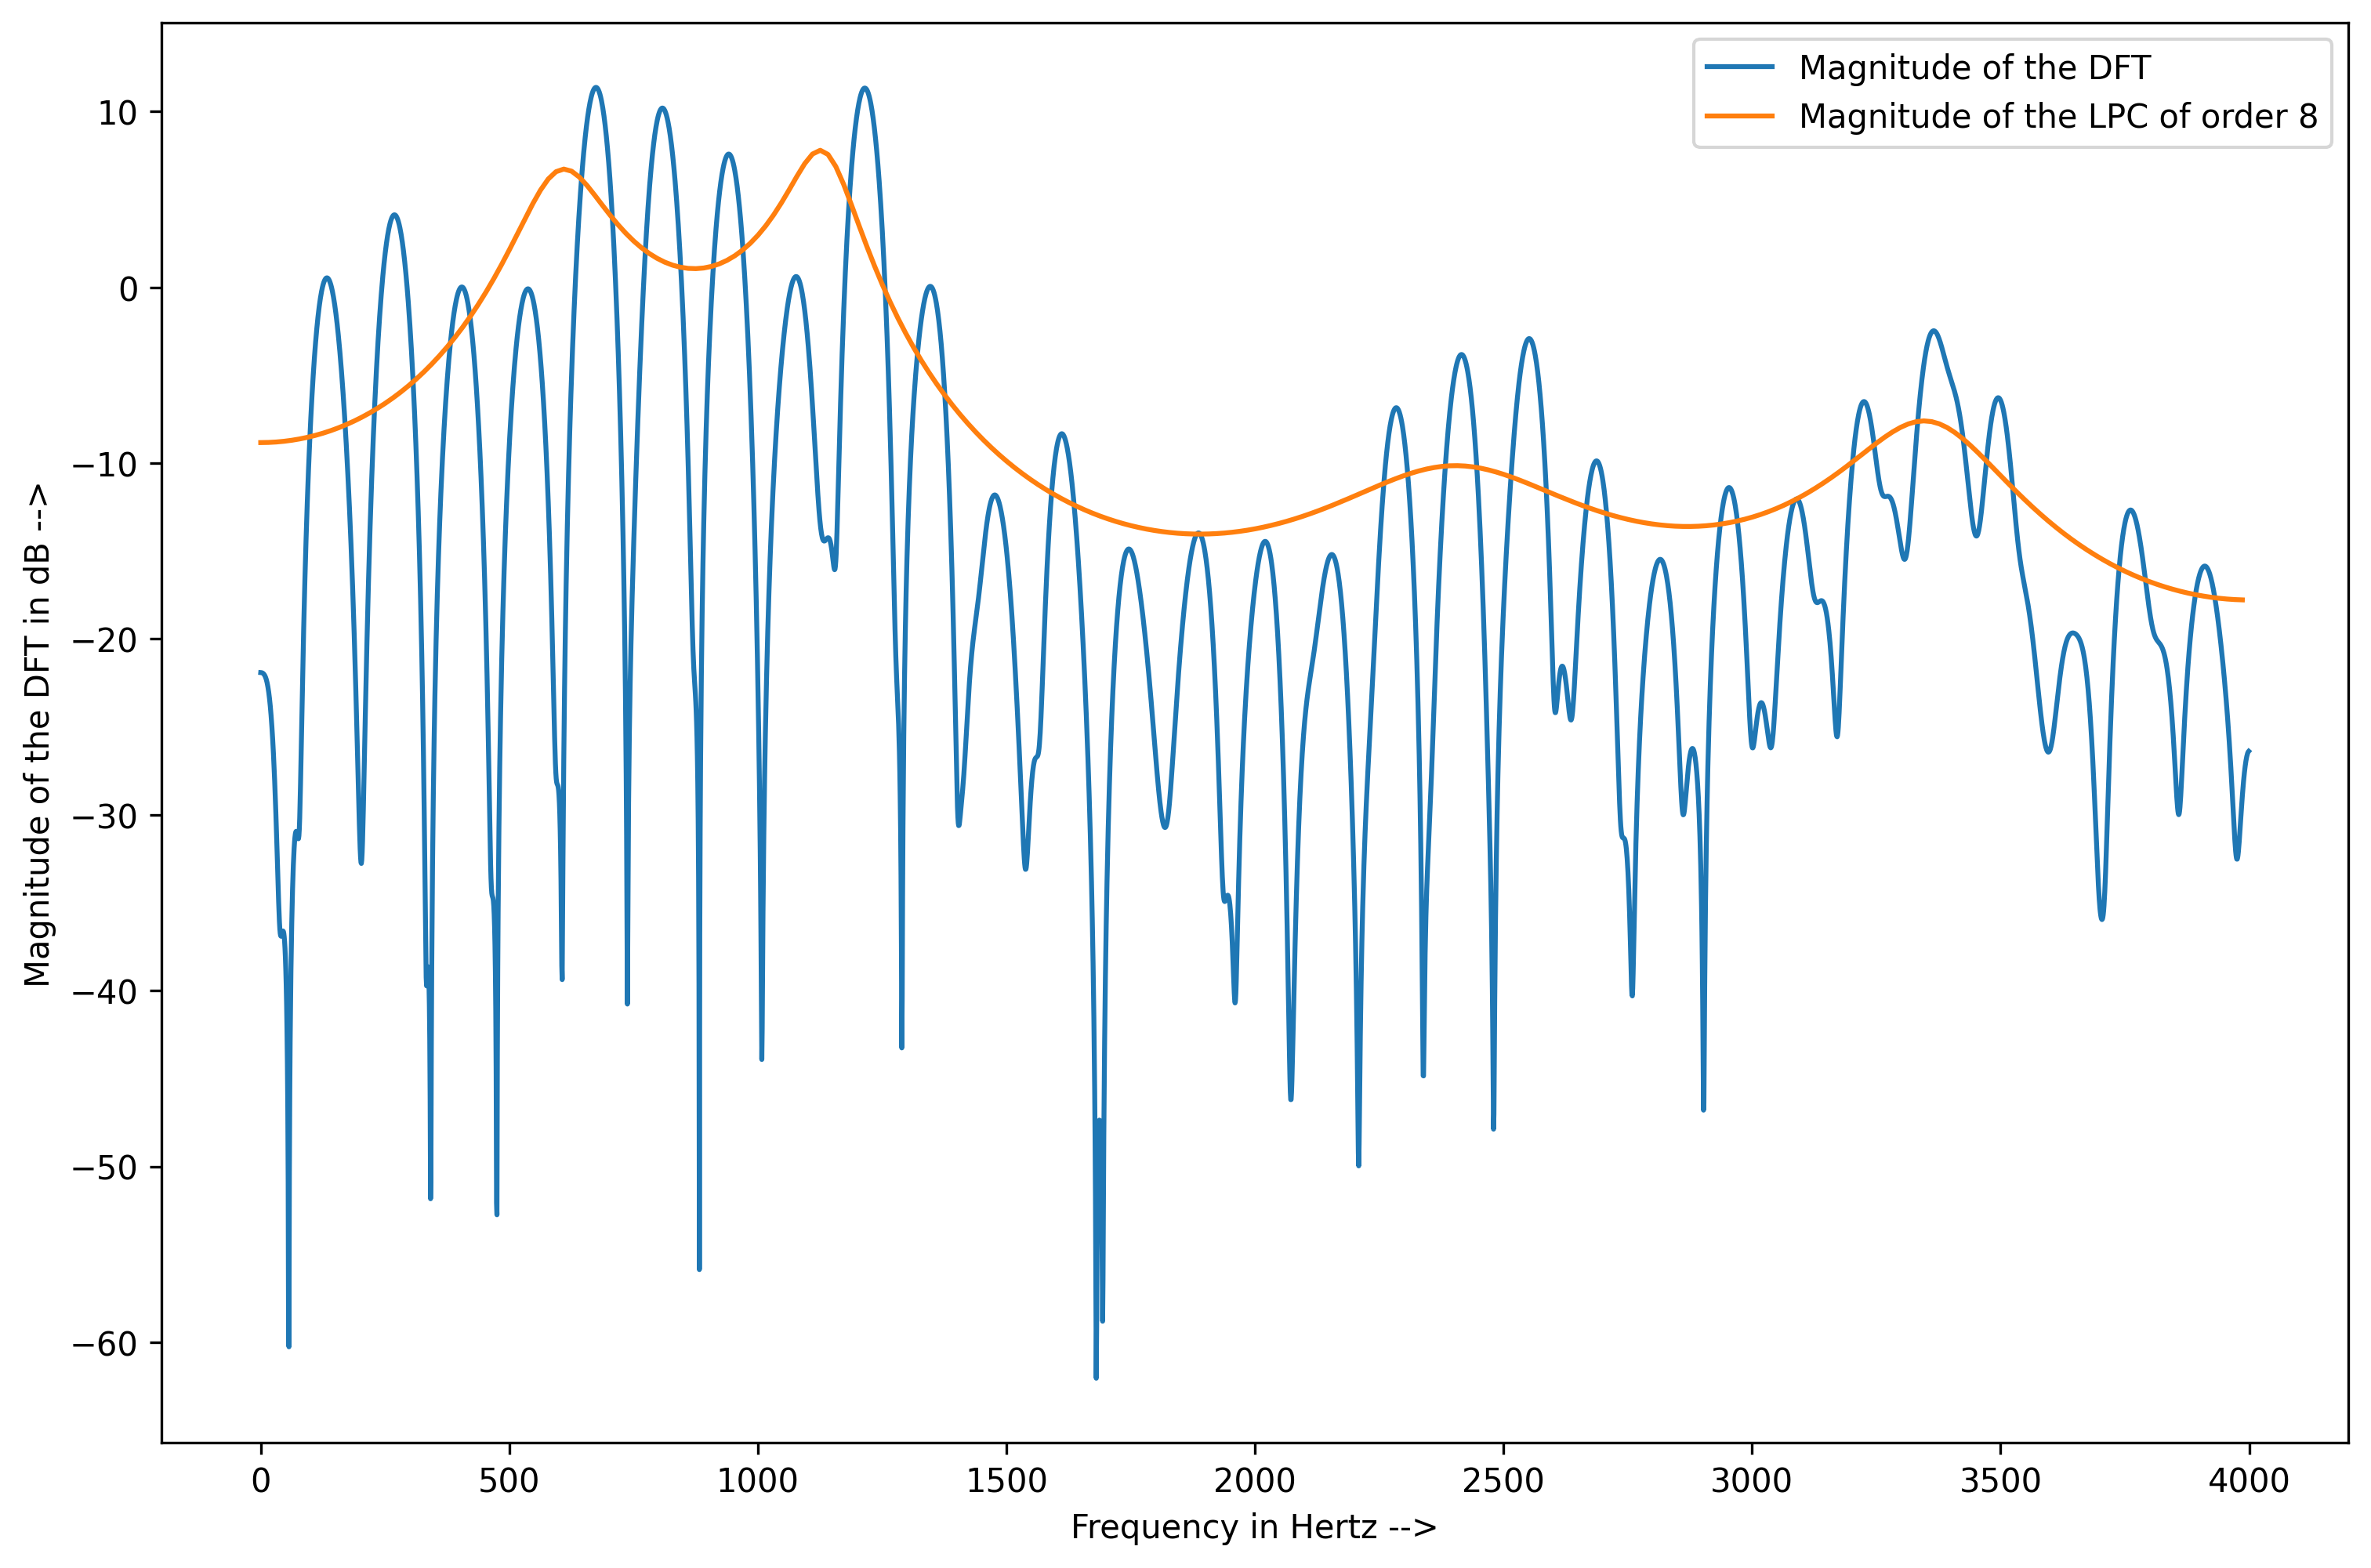

In [40]:
p = 8

signalToEstimate = np.pad(np.array(signalToAnalyse, dtype = float),(p, 3*len(signalToAnalyse)-p), 'constant')
signalEstimate = np.zeros_like(signalToEstimate)
for i in range(0, len(signalToAnalyse) + p-1):
    signalEstimate[i] = np.sum(signalToEstimate[i:(i+p)]*coef[p-1])

w, h = freqz(np.sqrt(Emin[p-1]), np.insert((-1*coef[p-1]),  0, 1), None, 1)

plt.figure(figsize=(12, 8)) #plotting the magnitude spectra for the windowed signal
plt.gcf().set_dpi(300)
#plt.subplot(121)
plt.plot(np.arange(0, 8000/2, 8000/dftSize)[0:], 20*np.log10(np.abs(np.fft.fft(signalAfterHamming, dftSize))[:dftSize//2]))
plt.plot(w[:int(len(w)/2)]*8000/(2*3.14), 20*np.log10(np.abs(h[:int(len(h)/2)])))  

plt.xlabel("Frequency in Hertz -->")
plt.ylabel("Magnitude of the DFT in dB -->")
plt.legend(["Magnitude of the DFT", f"Magnitude of the LPC of order {p}"])
# plt.subplot(122)
# f = interp1d(find_peaks(20*np.log(np.abs(np.fft.fft(signalToEstimate, dftSize))[:dftSize//2]))[0], 20*np.log(np.abs(np.fft.fft(signalToEstimate, dftSize))[:dftSize//2])[find_peaks(20*np.log(np.abs(np.fft.fft(signalToEstimate, dftSize))[:dftSize//2]))[0]], kind='cubic')
# xNew = np.array([i for i in range(21, 4000)])
# plt.plot(xNew, f(xNew), alpha = 0.3, linewidth = 0.9, color = 'g')
# plt.xlabel("Frequency in Hertz -->")
# plt.ylabel("Magnitude of the DFT in dB -->")
# plt.legend(["Interpolated Magnitude of the DFT"])

### For order p = 10

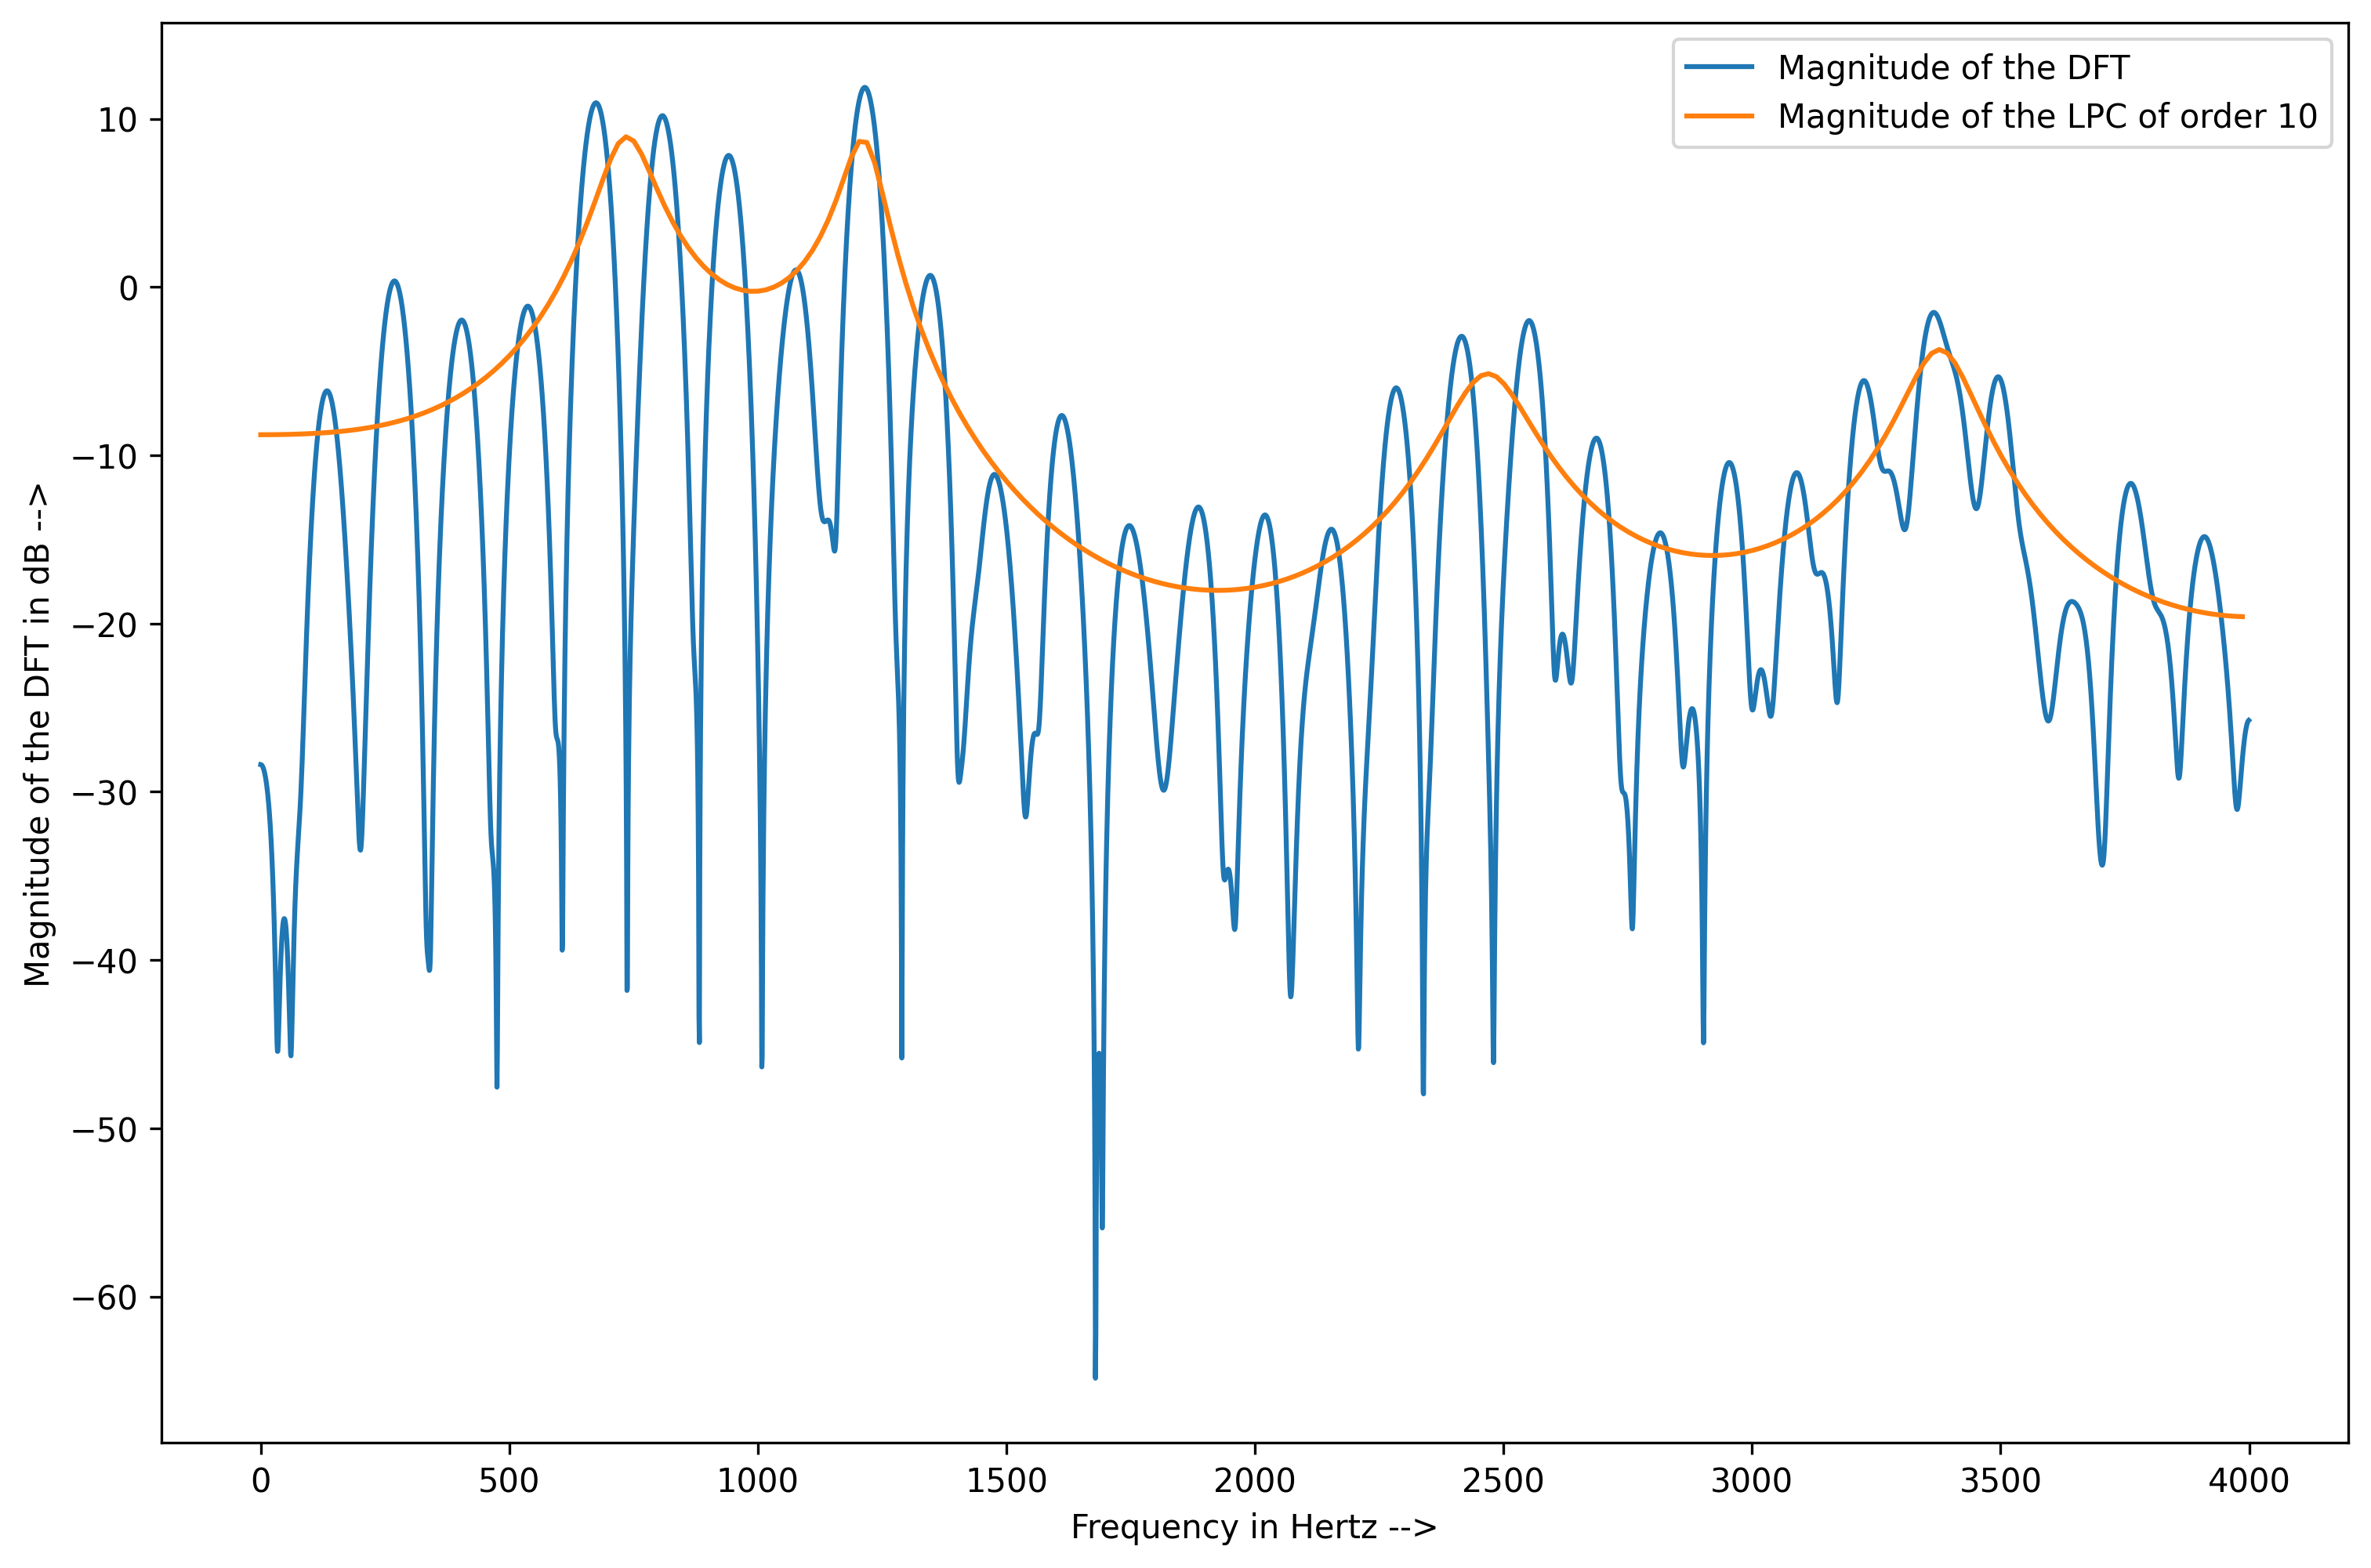

In [81]:
p = 10

signalToEstimate = np.pad(np.array(signalToAnalyse, dtype = float),(p, 3*len(signalToAnalyse)-p), 'constant')
signalEstimate = np.zeros_like(signalToEstimate)
for i in range(0, len(signalToAnalyse) + p-1):
    signalEstimate[i] = np.sum(signalToEstimate[i:(i+p)]*coef[p-1])

w, h = freqz(np.sqrt(Emin[p-1]), np.insert((-1*coef[p-1]),  0, 1), None, 1)

plt.figure(figsize=(12, 8)) #plotting the magnitude spectra for the windowed signal
plt.gcf().set_dpi(300)
#plt.subplot(121)
plt.plot(np.arange(0, 8000/2, 8000/dftSize)[0:], 20*np.log10(np.abs(np.fft.fft(signalAfterHamming, dftSize))[:dftSize//2]))
plt.plot(w[:int(len(w)/2)]*8000/(2*3.14), 20*np.log10(np.abs(h[:int(len(h)/2)])))  

plt.xlabel("Frequency in Hertz -->")
plt.ylabel("Magnitude of the DFT in dB -->")
plt.legend(["Magnitude of the DFT", f"Magnitude of the LPC of order {p}"])
# plt.subplot(122)
# f = interp1d(find_peaks(20*np.log(np.abs(np.fft.fft(signalToEstimate, dftSize))[:dftSize//2]))[0], 20*np.log(np.abs(np.fft.fft(signalToEstimate, dftSize))[:dftSize//2])[find_peaks(20*np.log(np.abs(np.fft.fft(signalToEstimate, dftSize))[:dftSize//2]))[0]], kind='cubic')
# xNew = np.array([i for i in range(21, 4000)])
# plt.plot(xNew, f(xNew), alpha = 0.3, linewidth = 0.9, color = 'g')
# plt.xlabel("Frequency in Hertz -->")
# plt.ylabel("Magnitude of the DFT in dB -->")
# plt.legend(["Interpolated Magnitude of the DFT"])

# Question 6
Based on the 10th-order LP coefficients, carry out the inverse filtering of the /a/ vowel
segment to obtain the residual error signal. Can you measure the pitch period of the
voiced sound from the residual waveform? Use the acf to detect the pitch. Compare the
acf plots of the original speech and residual signals. 


In [24]:
p = 10
signalToEstimate = np.pad(np.array(signalAfterHamming, dtype = float),(p, 3*len(signalAfterHamming)-p), 'constant')
signalEstimate = np.zeros_like(signalToEstimate)
for i in range(0, len(signalAfterHamming) + p-1):
    signalEstimate[i] = np.sum(signalToEstimate[i:(i+p)]*coef[p-1])

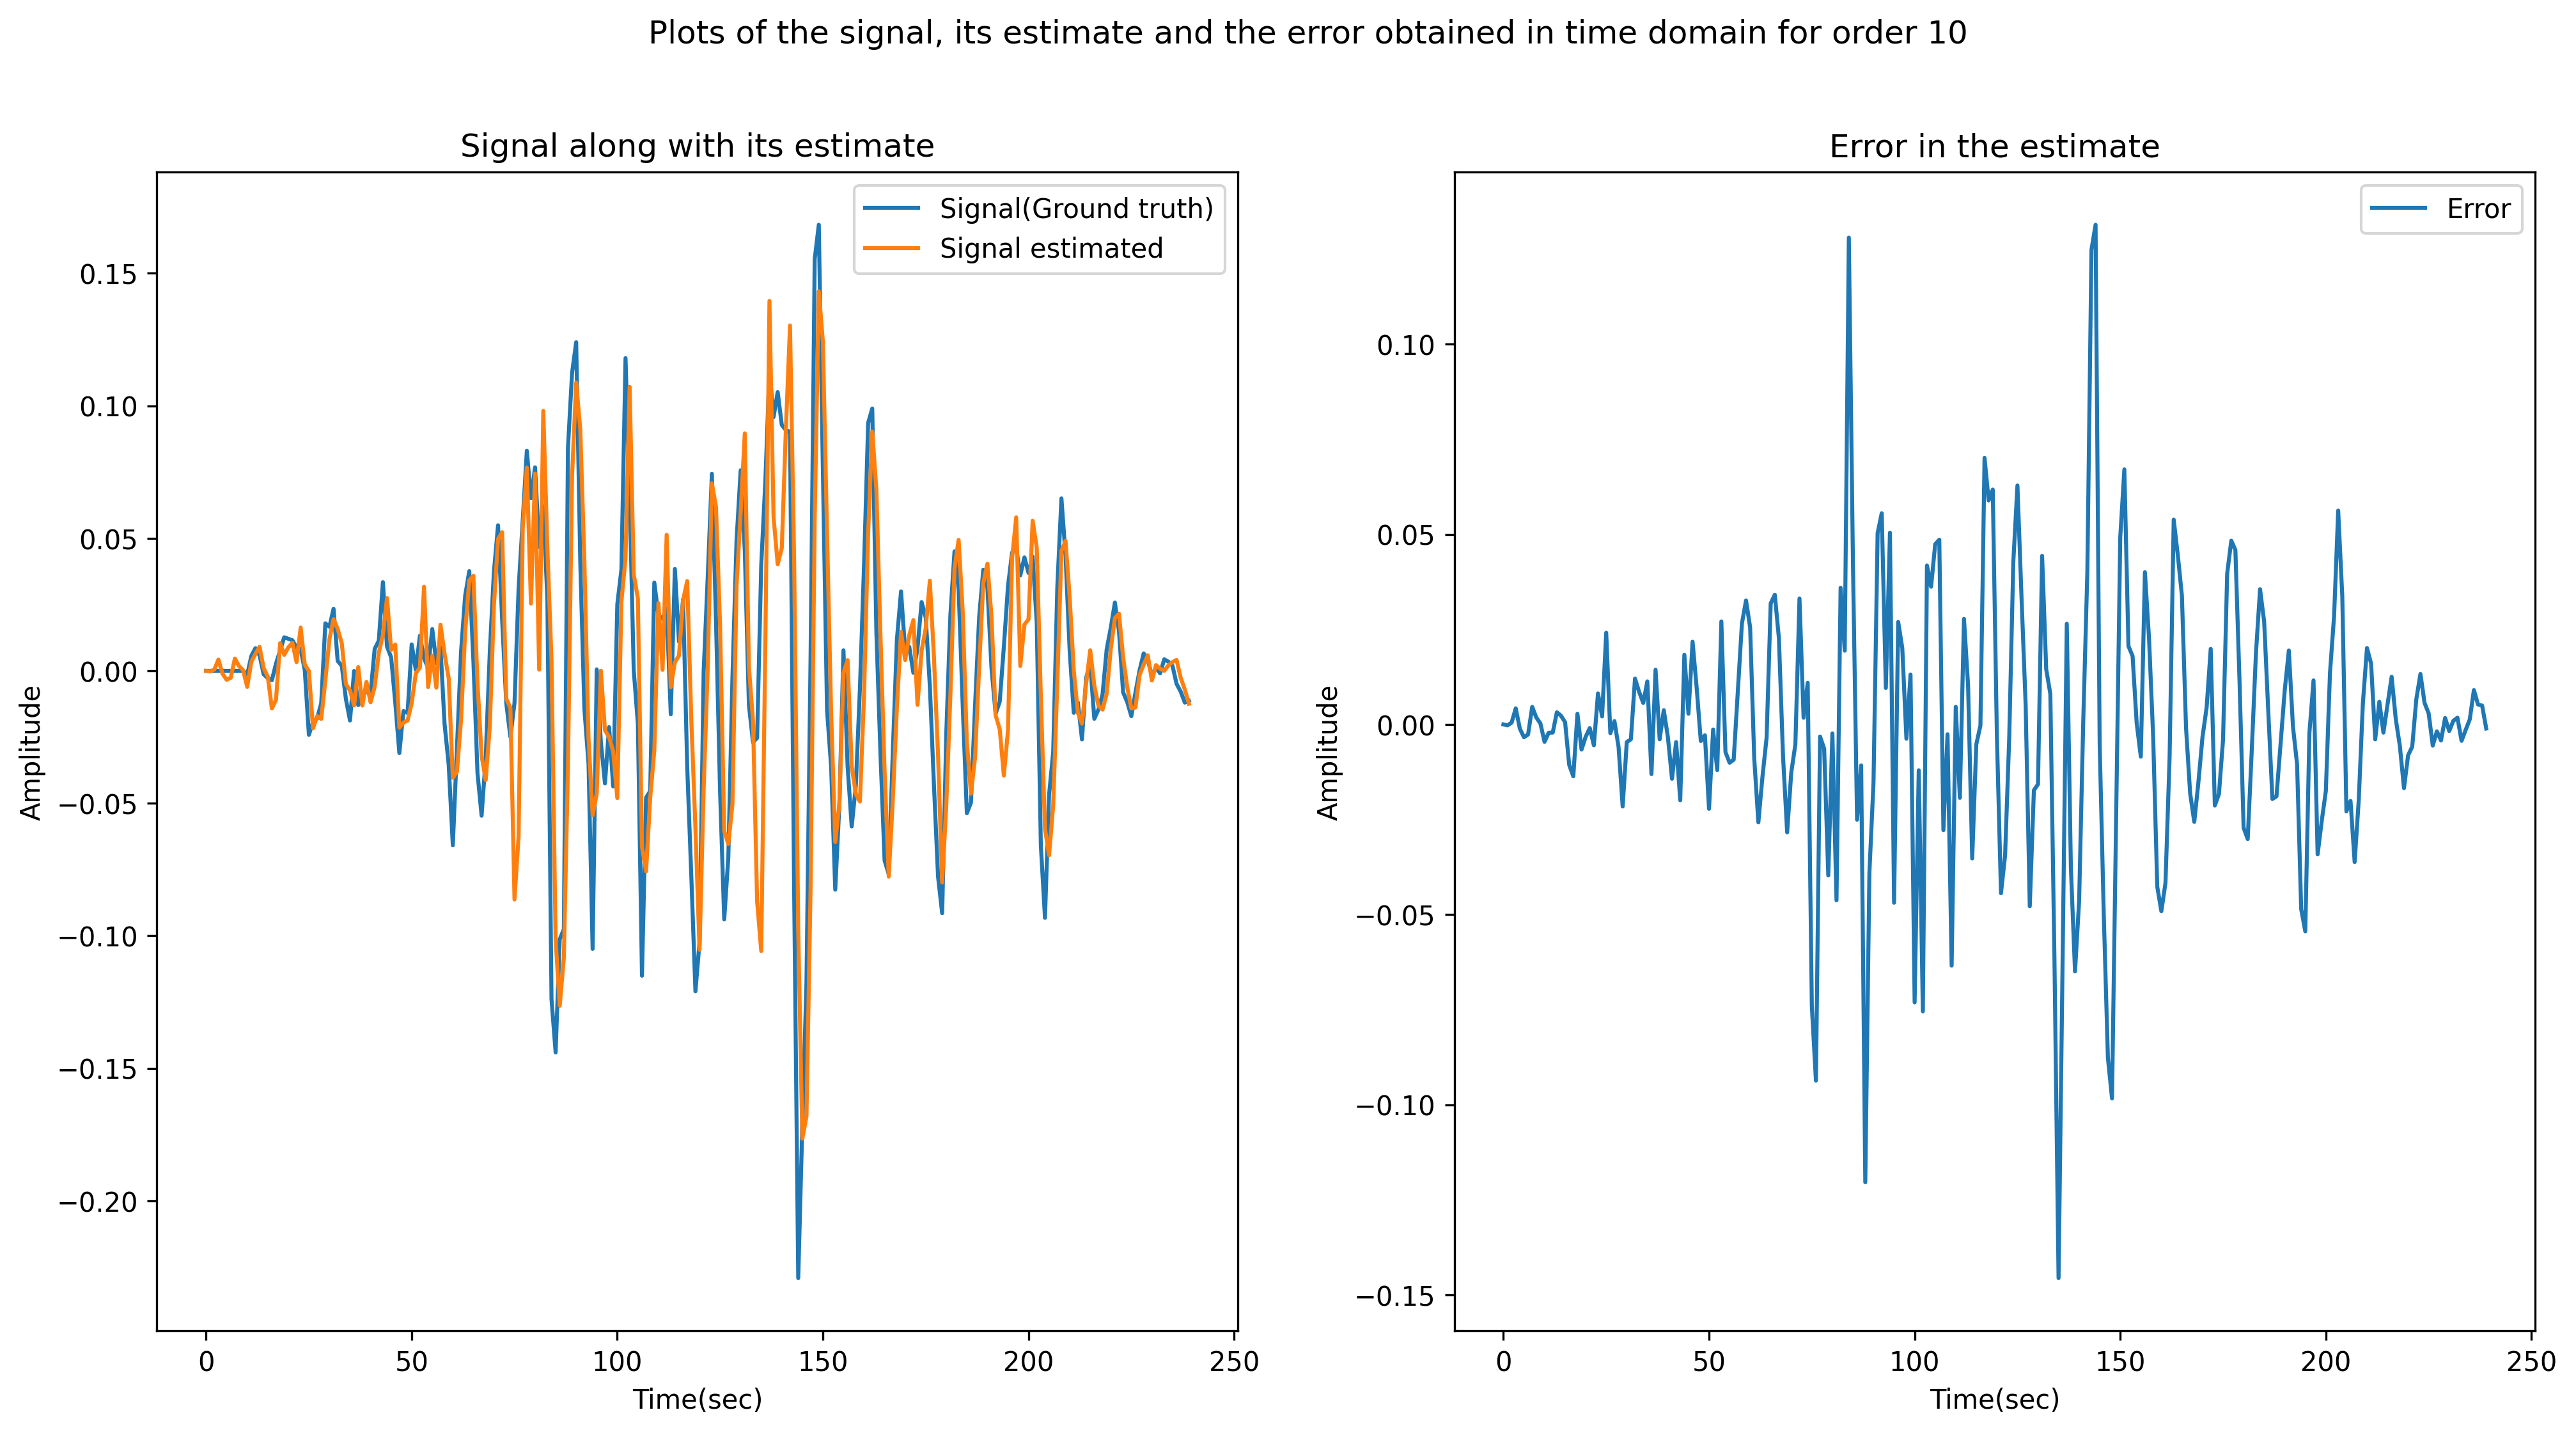

In [25]:
plt.figure(figsize = (16, 8))
plt.gcf().set_dpi(300)
plt.suptitle(f"Plots of the signal, its estimate and the error obtained in time domain for order {p}")
plt.subplot(121)
plt.plot(signalToEstimate[0:240], label = "Signal(Ground truth)")
plt.plot(signalEstimate[0:240], label = "Signal estimated")
plt.title("Signal along with its estimate")
plt.xlabel("Time(sec)")
plt.ylabel("Amplitude")
plt.legend()

plt.subplot(122)
plt.plot((signalEstimate -signalToEstimate)[0:240], label = "Error") 
plt.title("Error in the estimate")
plt.xlabel("Time(sec)")
plt.ylabel("Amplitude")
plt.legend()
plt.legend()

We need to change the amount of pre-emphasis added such that the error approximates a impulse train i.e the peaks should achieve roughly, the same amplitude.  Hence, we need to do a little trial and error here to findthe correct value of the pre-emphasis to add.

In the above figure, in the error plot we see that the amplitudes acheved by the global peaks are the same and hence, more or less approximate an impulse train.

Text(0, 0.5, 'ACF Value')

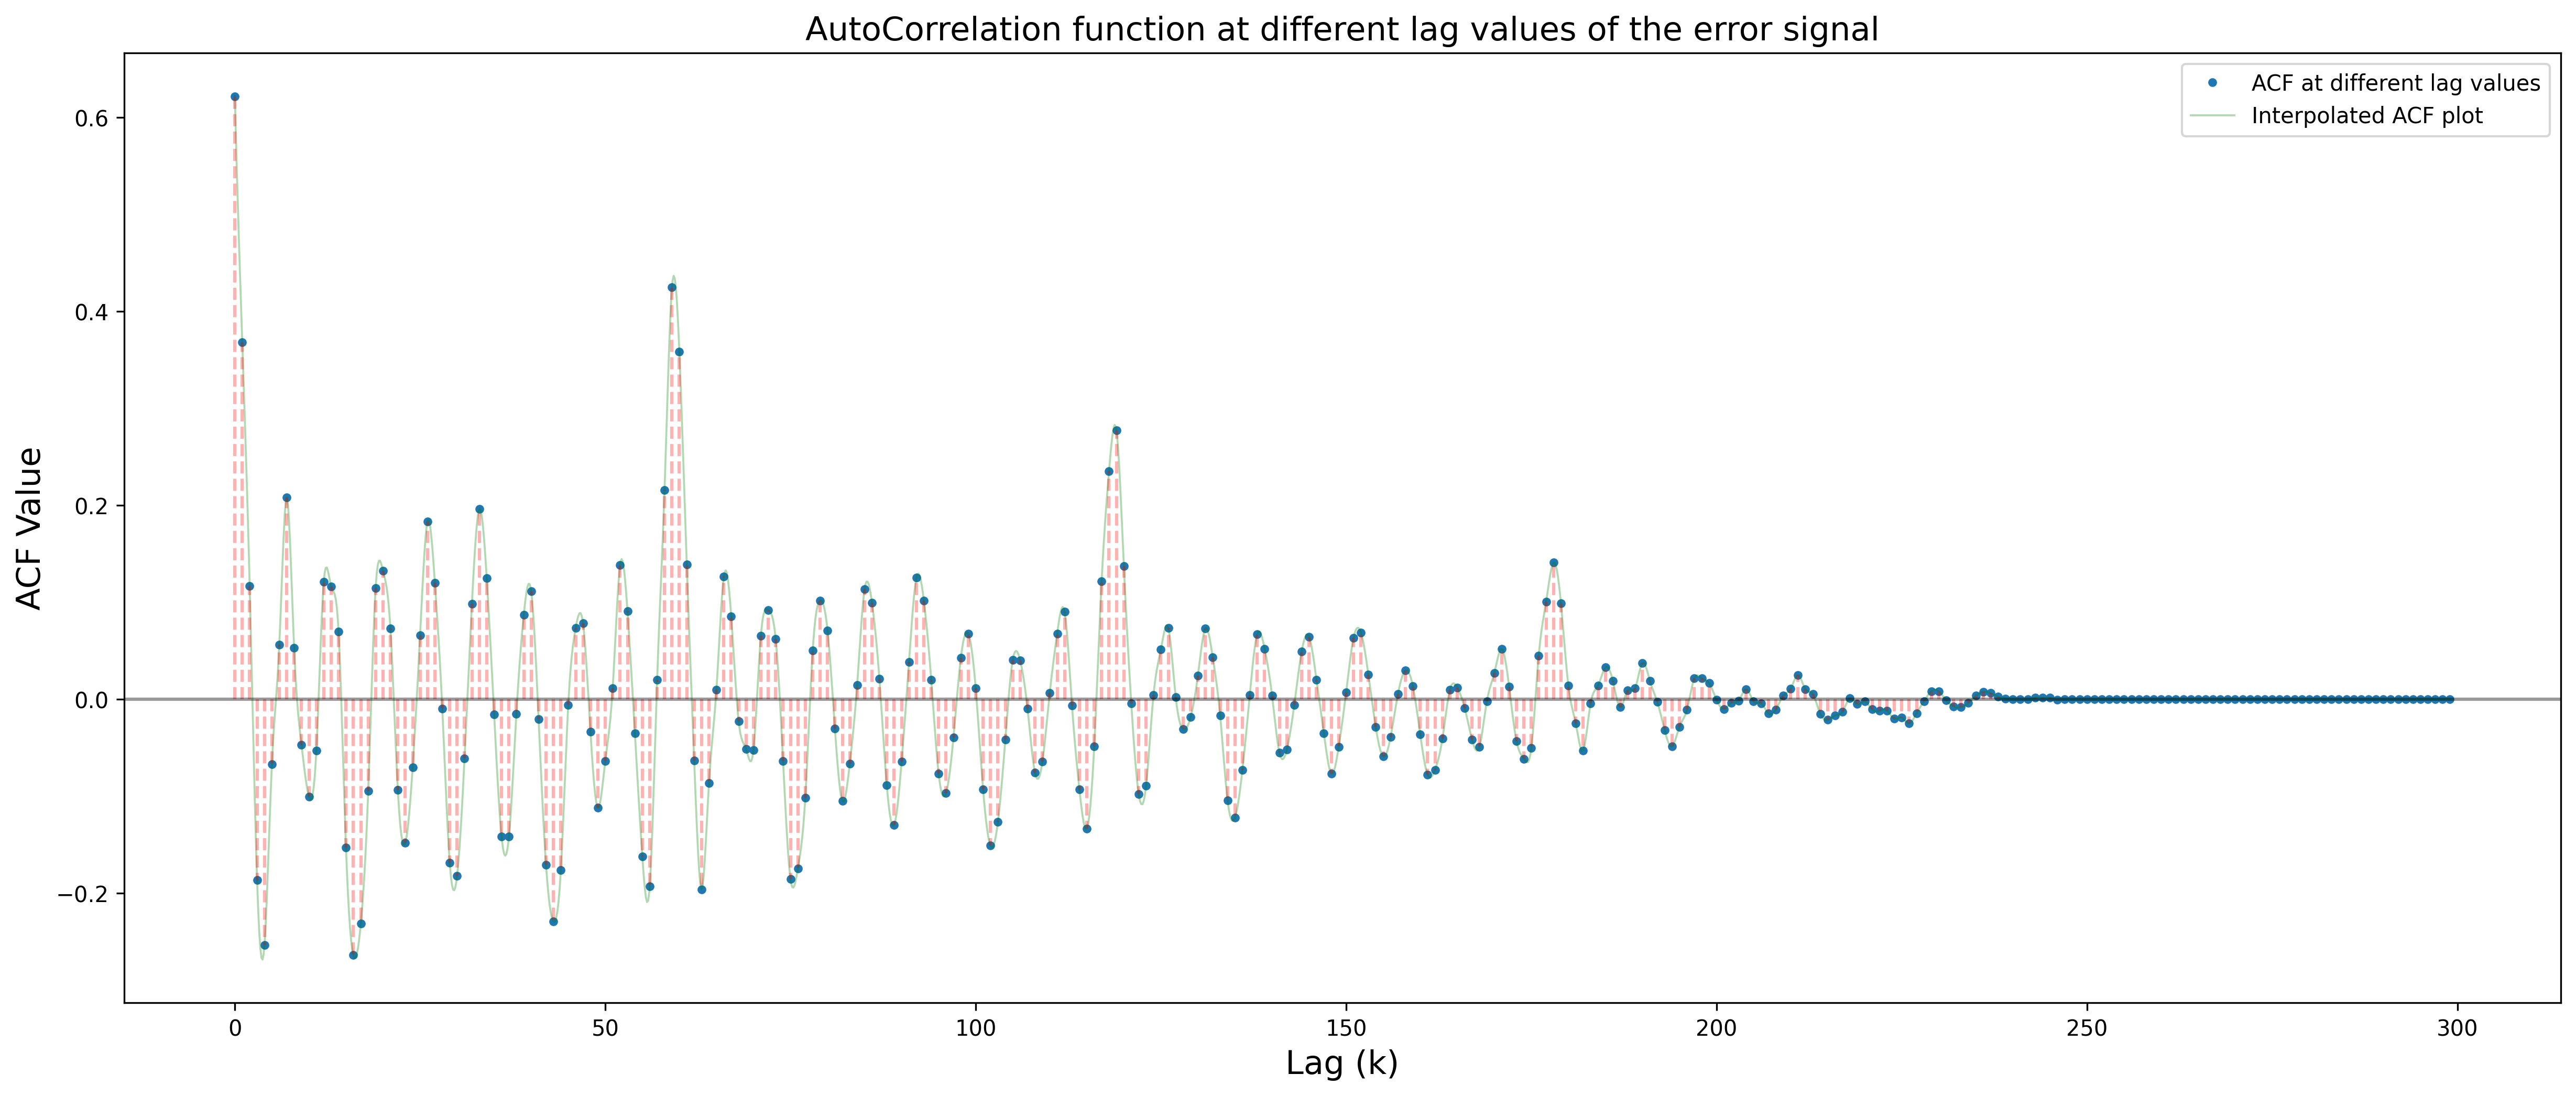

In [42]:
k = [i for i in range(0, 300)]
x = np.linspace(0, 299, 2000)
acf = [computeACF(signalEstimate -signalToEstimate, i) for i in range(0, 300)]
plt.figure(figsize = (20, 8))
plt.gcf().set_dpi(300)
plt.plot(k, acf,'.')
f = interp1d(k, acf, kind='cubic')
plt.plot(x, f(x), alpha = 0.3, linewidth = 0.9, color = 'g')
plt.vlines(k, 0, acf, color='r', linestyles='--', alpha = 0.3)
plt.axhline(0, color = 'k', alpha = 0.4)
plt.legend(["ACF at different lag values", "Interpolated ACF plot"])
plt.title("AutoCorrelation function at different lag values of the error signal", fontsize= 15)
plt.xlabel("Lag (k)", fontsize= 15)
plt.ylabel("ACF Value", fontsize= 15)

Referring the Question 3 we have the original ACF plot of the signal.

Comparing the two, we have : 
1. Both of them peak at nearly 59 samples (i.e 59 $\times \frac{1}{8000} = 7.375$ micro-seconds).
2. The above behaviour is expected since, both signals have the underlying pitch(glottal vabrations)
3. Thus, the estimated pitch is $\frac{1}{7.375ms} = 135.925Hz$

# Question 7
LP re-synthesis: We analysed a natural speech sound /a/ above. 

Using a suitable set of
parameter estimates as obtained there, we wish to reconstruct the sound.
That is, use the best estimated LP filter with an ideal impulse train of the estimated pitch
period as source excitation. 

Carry out de-emphasis on the output waveform. Set the
duration of the synthesized sound to be 300 ms at 8 kHz sampling frequency and view
the waveform as well as listen to your created sound.


Comment on the similarity with the original sound. Try out voice modification using
this analysis-synthesis method (e.g. change the voice pitch). 

We will use the order 10 filter.

Say u[n] is our impulse train. Clearly, u[n] = 1 when n = $k \times T$ else u[n] = 0 where T is the pitch of the signal i.e. 59 samples as calculated in the previous question.

To calculate the output(estimated signal), we need to set up the difference equation as follows:

We know our filter looks like :
$$A(z) = \frac{G}{1 - \sum_{k = 1}^{k=P}a_k z^{-k}}$$
$$\implies y[n] - \sum_{k = 1}^{k=P}a_k y[n-k] = Gx[n]$$

$$\implies y[n] = Gx[n] + \sum_{k = 1}^{k=P}a_k y[n-k]$$

We assume that the signal y[n] is causal and x[n] is our impulse i.e. impulse train

Text(0.5, 1.0, 'Impulse train generated')

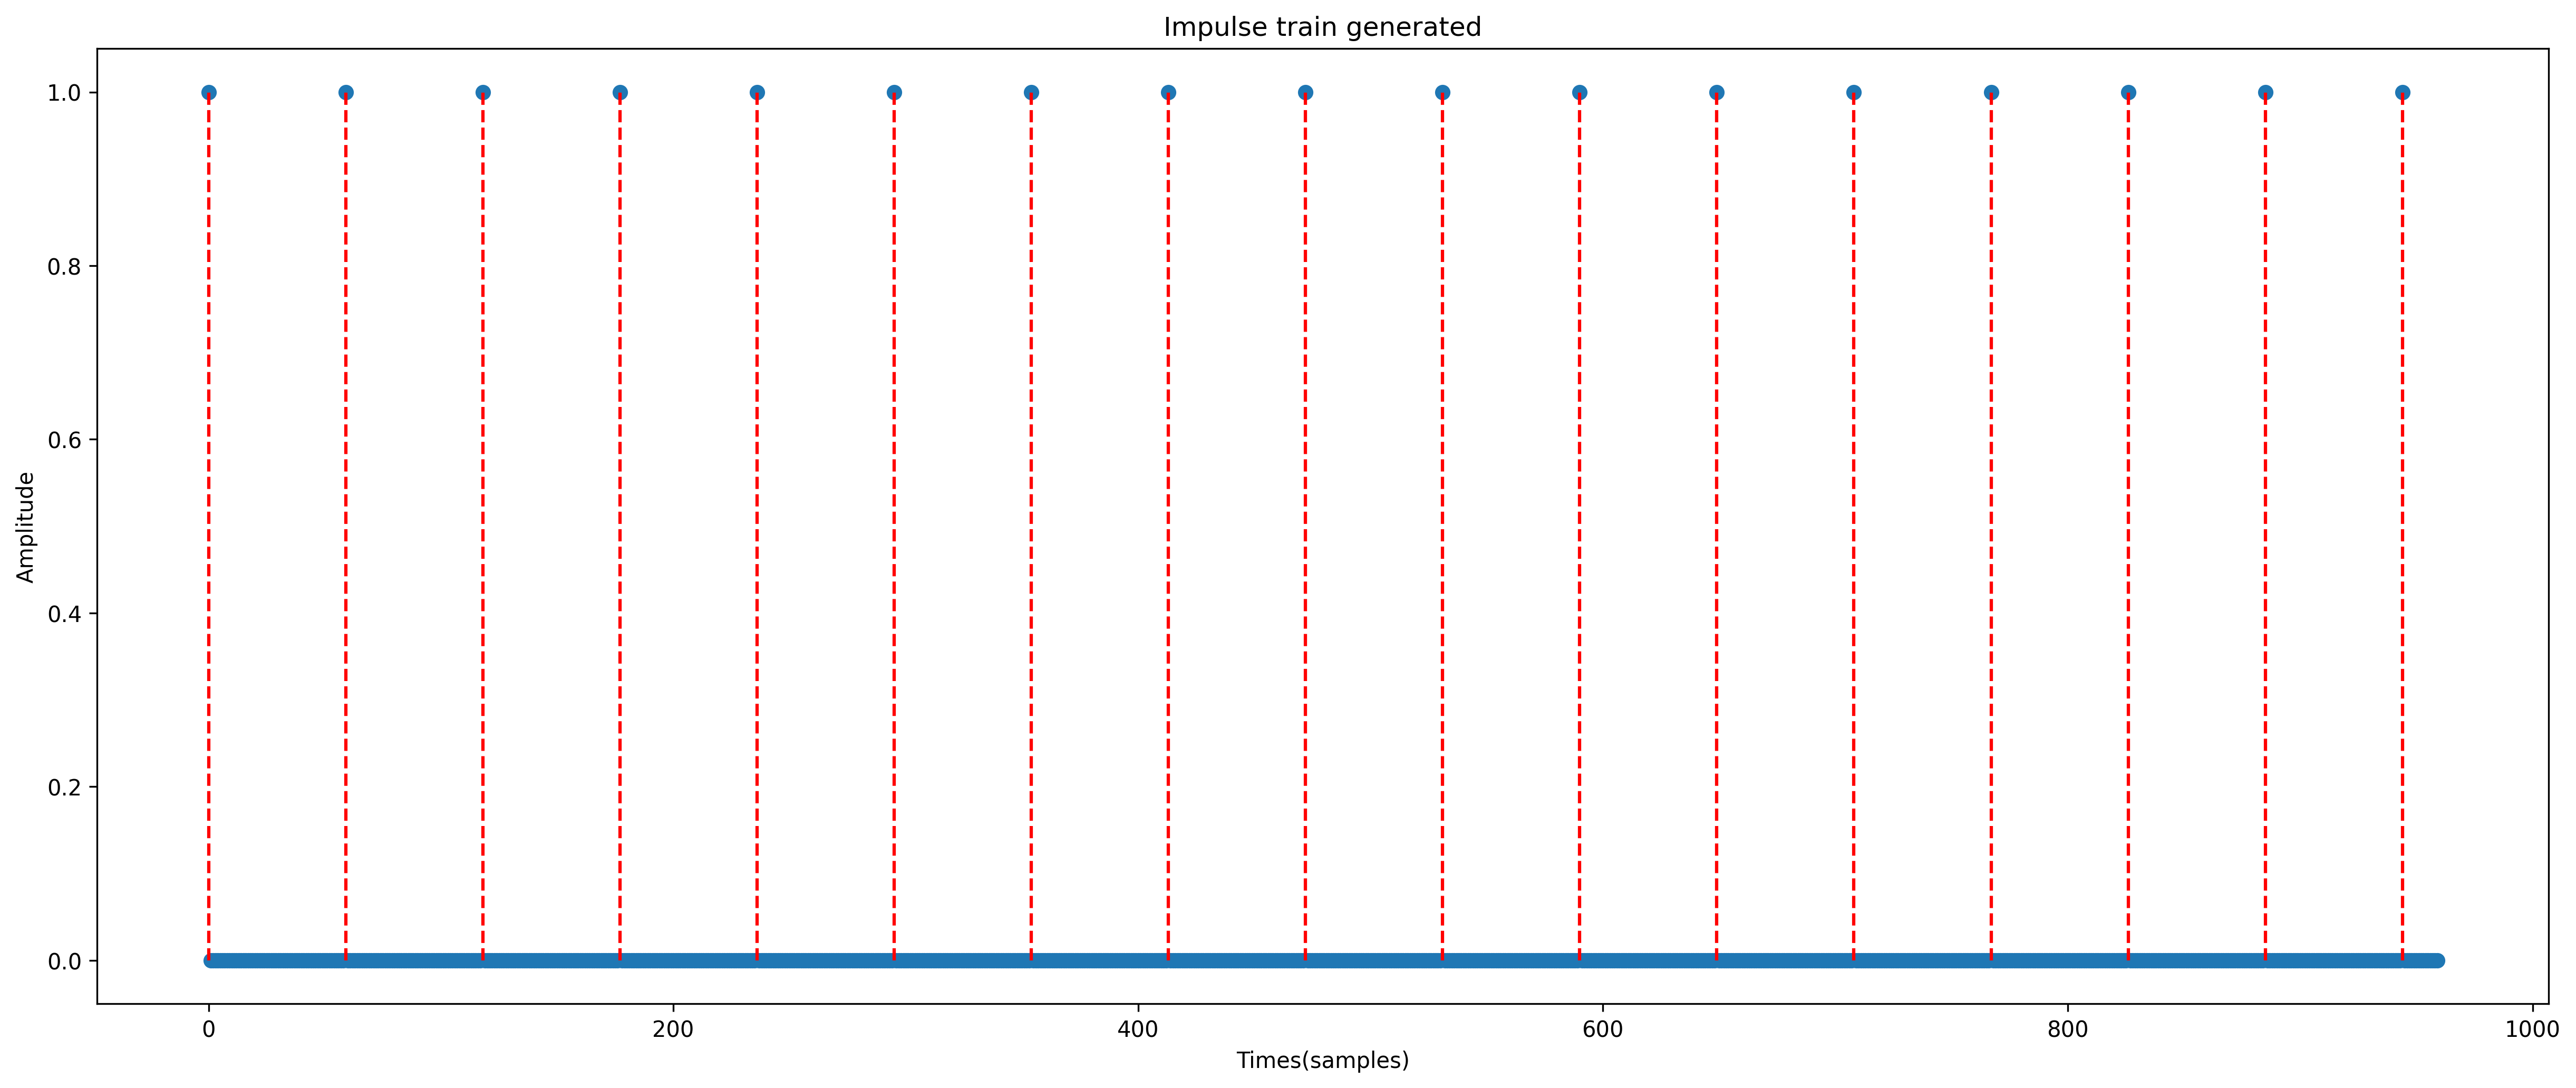

In [81]:
signalToEstimate = np.pad(np.array(signalAfterHamming, dtype = float),(0, 3*len(signalAfterHamming)), 'constant')
signalReconstructed = np.zeros_like(signalToEstimate)
inputImpulseTrain = np.zeros_like(signalToEstimate)
inputImpulseTrain[[i for i in range(0, signalToEstimate.shape[0], 59)]] = 1
plt.figure(figsize = (20, 8))
plt.gcf().set_dpi(300)
plt.plot(inputImpulseTrain, 'o')
plt.vlines(np.arange(0, signalToEstimate.shape[0], 59), 0, 1, colors = 'r', linestyles='--')
plt.xlabel("Times(samples)")
plt.ylabel("Amplitude")
plt.title("Impulse train generated")

In [100]:
P = 40#choosing the order of analysis
G = np.sqrt(Emin[P-1])
inputImpulseTrain = np.pad(np.array(inputImpulseTrain, dtype = float),(P, 0), 'constant')
#signal y[n] is assumed casual
for i in range(P, signalToEstimate.shape[0] - P):
    signalReconstructed[i] = G*inputImpulseTrain[i] + np.sum(signalReconstructed[i-P:i]*coef[P-1])


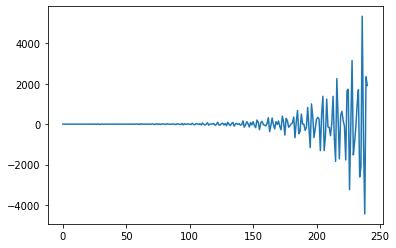

In [101]:
plt.plot(signalReconstructed[10:251])